# Flagellin database description - phylosignal on sequence length

### Load libraries

In [295]:
library(gridExtra)
library(grid)
library(ggplot2)
library(lattice)

In [1]:
library(seqinr)
library(tidyverse)
library(ape)
library(phyloseq)
library(phylosignal)
library(picante)
library(phylosignal)
library(phytools)
library(phangorn)
library(gridExtra)
library(ggtree)
library(phylotools)
library(reshape2)
library(ggpubr)

── Attaching packages ──────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ─────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::count()  masks seqinr::count()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘ape’


The following object is masked from ‘package:dplyr’:

    where


The following objects are masked from ‘package:seqinr’:

    as.alignment, consensus


Loading required package: vegan

Loading required package: permute


Attaching package: ‘permute’


The following object is masked from ‘package:seqinr’:

    getType


Loading required package: lattice


Attaching package: ‘lattice’


The following object is masked from ‘package:phylosignal’:

    dotplot


This is vegan 2.6-4

Loading

In [20]:
library(ggsci)

In [398]:
#Path to the figures folder
figures_path = "/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures"

### Get sequence lengths from AA sequences

In [2]:
flagellins.full.db = seqinr::read.fasta("../flagellin_phylogeny/curatedFlagellin.db_24915seqs.fasta")

In [3]:
length.seqs.full.db=as_tibble(getName(flagellins.full.db))%>%
            mutate(seqLength=getLength(flagellins.full.db))%>%
            #mutate(HVR_length=length-240)%>%
            rename(Accession="value")

### Add taxonomy + GTDB metadata to flagellin sequences

In [275]:
taxonomy.full.db=read_tsv("/ebio/abt3_projects/small_projects/aborbon/Thesis_FlagellinDiversity/1_shortbred/flagellin_phylogeny/taxonomy.gtdb.full.db.txt")%>%
separate(gtdb_taxonomy,into=c("Domain","Phylum","Class","Order","Family","Genus","Species"),sep=";") %>%
mutate(Domain = str_remove_all(Domain,"d__"))%>%
mutate(Phylum = str_remove_all(Phylum,"p__"))%>%
mutate(Class = str_remove_all(Class,"c__"))%>%
mutate(Order = str_remove_all(Order,"o__"))%>%
mutate(Family = str_remove_all(Family,"f__"))%>%
mutate(Genus = str_remove_all(Genus,"g__"))%>%
mutate(Species = str_remove_all(Species,"s__"))

Rows: 26392 Columns: 117
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (73): Accession, ncbi_phylum, ncbi_class, ncbi_order, ncbi_family, ncbi...
dbl  (37): ncbi_taxid, ambiguous_bases, checkm_completeness, checkm_contamin...
lgl   (5): gtdb_representative, gtdb_type_species_of_genus, mimag_high_quali...
date  (2): ncbi_date, ncbi_seq_rel_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [276]:
full.db.taxonomy.length=inner_join(length.seqs.full.db,taxonomy.full.db,by="Accession")%>%
select(c(contains(c("genome","assembly")),"Accession","seqLength","ncbi_taxid","ncbi_phylum","genome_size","Domain","Phylum","Class","Order","Family","Genus","Species"))

In [277]:
count_phylum.full.db = count(full.db.taxonomy.length,Phylum,sort=TRUE)

In [7]:
#descriptive stats
data.frame(
    "statistic" = c("median","MAD","IQR","mean","SD"),
    "value" = c(median(count_phylum.full.db$n), 
              mad(count_phylum.full.db$n),
              IQR(count_phylum.full.db$n),
              mean(count_phylum.full.db$n),
              sd(count_phylum.full.db$n))
    )

statistic value    
1 median      14.5000
2 MAD         19.2738
3 IQR         72.2500
4 mean       622.8750
5 SD        2505.1844

In [278]:
count.taxonomy.fulldb = count(full.db.taxonomy.length,Species,Genus,Family,Order,Class,Phylum,sort=TRUE)

In [279]:
head(count.taxonomy.fulldb)

Species                 Genus           Family             Order            
1 Escherichia coli_D      Escherichia     Enterobacteriaceae Enterobacterales 
2 Campylobacter_D jejuni  Campylobacter_D Campylobacteraceae Campylobacterales
3 Salmonella enterica     Salmonella      Enterobacteriaceae Enterobacterales 
4 Bacillus_A cereus       Bacillus_A      Bacillaceae_G      Bacillales       
5 Campylobacter_D coli    Campylobacter_D Campylobacteraceae Campylobacterales
6 Vibrio parahaemolyticus Vibrio          Vibrionaceae       Enterobacterales 
  Class               Phylum           n  
1 Gammaproteobacteria Proteobacteria   737
2 Campylobacteria     Campylobacterota 718
3 Gammaproteobacteria Proteobacteria   622
4 Bacilli             Firmicutes       431
5 Campylobacteria     Campylobacterota 392
6 Gammaproteobacteria Proteobacteria   372

In [10]:
genome.acc=count(taxonomy.full.db,accession,sort=TRUE)

In [11]:
nrow(count(taxonomy.full.db,gtdb_genome_representative))

[1] 6428

In [513]:
full.db.taxonomy.length = full.db.taxonomy.length %>%
            mutate(over1000 = ifelse(seqLength>=1000,TRUE,FALSE))

### Per taxonomic rank summary

In [12]:
nrow(count(taxonomy.full.db,Phylum))

[1] 61

In [13]:
stats.full.db = data.frame (rank = c("Phylum","Class","Order","Family","Genus","Species"),
           number = c(nrow(count(full.db.taxonomy.length,Phylum)),
                      nrow(count(full.db.taxonomy.length,Class)),
                      nrow(count(full.db.taxonomy.length,Order)),
                      nrow(count(full.db.taxonomy.length,Family)),
                      nrow(count(full.db.taxonomy.length,Genus)),
                      nrow(count(full.db.taxonomy.length,Species))),
           total.gtdb = c(161,488,1624,4264,19153,80789)) #obtained from GTDB website
stats.full.db 

rank    number total.gtdb
1 Phylum    40     161     
2 Class     86     488     
3 Order    206    1624     
4 Family   423    4264     
5 Genus   1606   19153     
6 Species 5931   80789

In [97]:
sd(full.db.taxonomy.length$seqLength)

[1] 120.2218

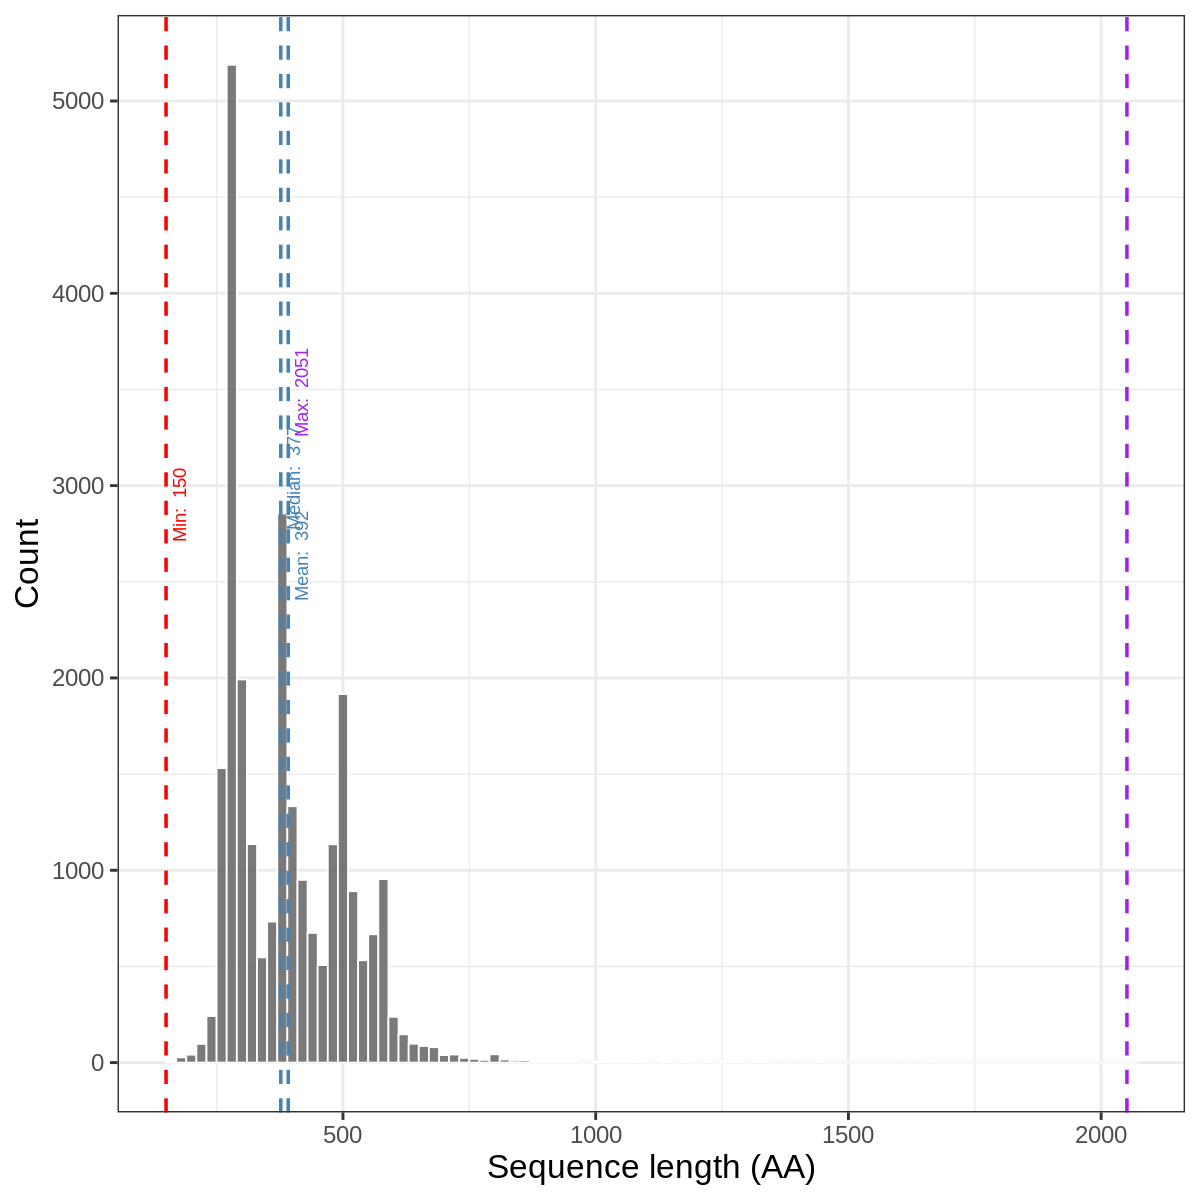

In [437]:
ggplot(data=full.db.taxonomy.length, aes(x=seqLength)) +
  geom_histogram(binwidth=20, alpha=0.8, color="white") +
  theme_bw(base_size=18) +
  labs(x="Sequence length (AA)", y="Count") +
  theme(axis.title=element_text(size=20), plot.title=element_text(size=24, face="bold")) +
#geom_vline(xintercept=median(fla.taxonomy.length$length), color="orange", size=1, linetype="dashed") +

geom_vline(xintercept=mean(full.db.taxonomy.length$seqLength), color="steelblue", size=1, linetype="dashed") +
annotate("text", x=mean(full.db.taxonomy.length$seqLength), y=12, label=paste("Mean: ", round(mean(full.db.taxonomy.length$seqLength), 0)), hjust=-5.1,vjust=1.5,angle=90, color="steelblue") +

geom_vline(xintercept=median(full.db.taxonomy.length$seqLength), color="steelblue", size=1, linetype="dashed") +
annotate("text", x=median(full.db.taxonomy.length$seqLength), y=12, label=paste("Median: ", round(median(full.db.taxonomy.length$seqLength), 0)), hjust=-5.1,vjust=1.5,angle=90, color="steelblue") +

 
geom_vline(xintercept=min(full.db.taxonomy.length$seqLength), color="red", size=1, linetype="dashed") +
annotate("text", x=min(full.db.taxonomy.length$seqLength), y=12, label=paste("Min: ", round(min(full.db.taxonomy.length$seqLength), 0)), hjust=-7,vjust=1.5,angle=90, color="red") +

geom_vline(xintercept=max(full.db.taxonomy.length$seqLength), color="purple", size=1, linetype="dashed")+
annotate("text", x=mean(full.db.taxonomy.length$seqLength), y=12, label=paste("Max: ", round(max(full.db.taxonomy.length$seqLength), 0)), hjust=-7,vjust=1.5,angle=90, color="purple")

### Top 10% flagellins

In [280]:
sorted.phylum = count(full.db.taxonomy.length,Family,Phylum,sort=TRUE)

Selecting by n


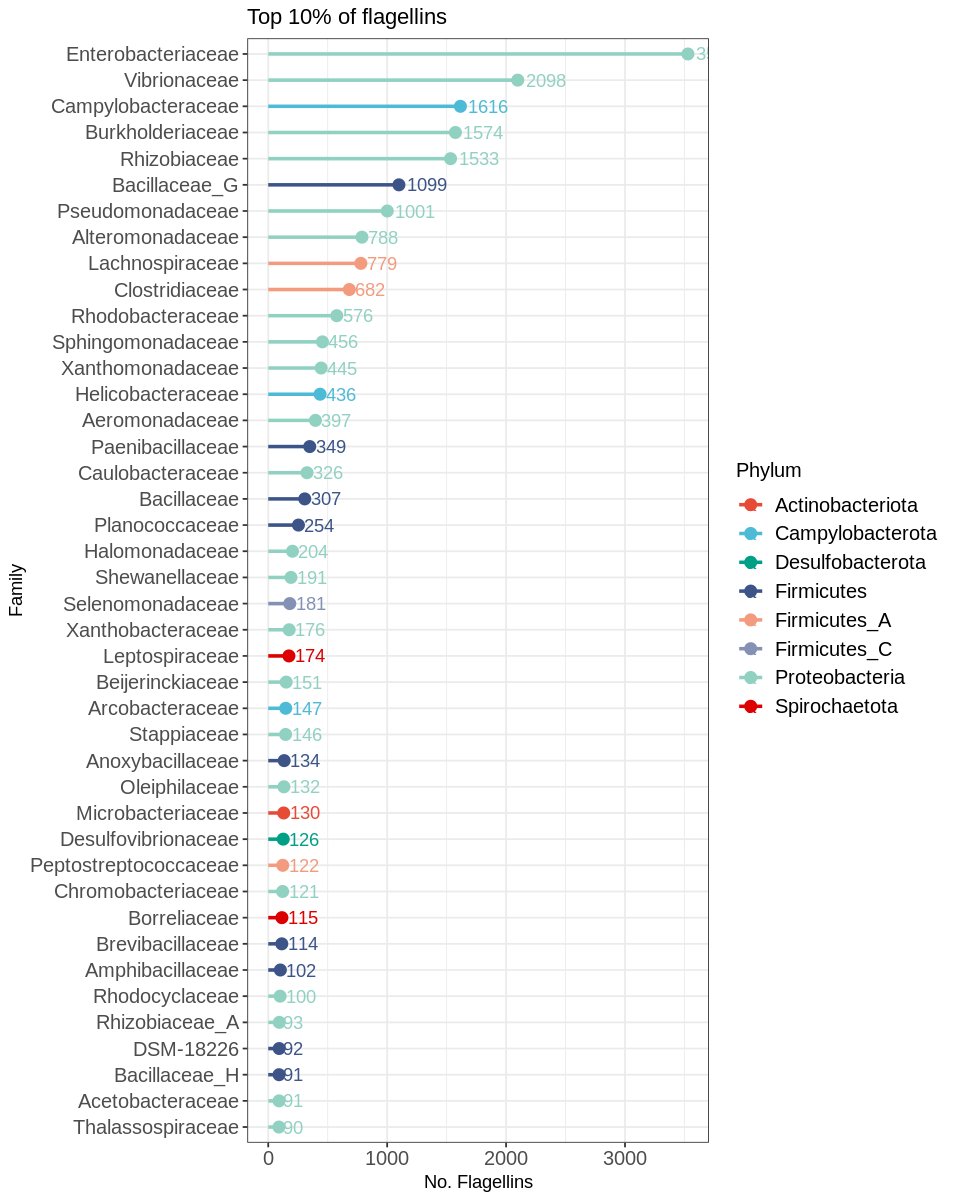

In [281]:
ggplot(filter(sorted.phylum) %>% top_frac(0.1),
                          aes(y=reorder(Family,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Family,xend=0),size=1)+
                        geom_point(size=3)+
                        geom_text(aes(label = n), hjust = -0.2) +
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 10% of flagellins")+
                        theme(axis.text.x= element_text(size=12),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )

In [23]:
# % of flagellin sequences contained in the top 5% of families (sorted by flagellin abundance)
(sum(top5.full$n)/sum(sorted.phylum$n))*100 #total top 5%
(sum(subset(top5.full,Family=="f__Enterobacteriaceae")$n)/sum(sorted.phylum$n))*100 # subset Enterobacteriaceae

[1] 74.81437

[1] 14.16416

## Plots thesis

### Figure 1

In [414]:
count.plot = ggplot(data=stats.full.db,aes(x=reorder(rank,number),y=number))+
geom_bar(stat="identity",alpha=1,fill="#335c67")+
geom_text(aes(label = number), vjust = -0.2,size=5) +
labs(x="",y="Count")+
theme_classic()+
theme(axis.text.x= element_text(size=16,angle=45,vjust=0.5),
      axis.text.y=element_text(size=16),
      axis.title.y = element_text(size=16),
      legend.title = element_text(size=12),
      plot.margin = margin(t=10,r=10,l=10,b=10),
      plot.title = element_text(hjust = 0.5),
      plot.tag = element_text(size=20,face="bold"))+
      labs(tag = "A")


In [415]:
count.plot

In [15]:
melt.stats.full.db = melt(stats.full.db)
names(melt.stats.full.db)

Using rank as id variables



[1] "rank"     "variable" "value"

In [16]:
prop.stats.full.db = transform(melt.stats.full.db,prop=value/tapply(value,rank,sum)[rank])

In [419]:

prop.plot = ggplot(data=prop.stats.full.db,aes(x=reorder(rank,value),y=prop,fill=variable))+
    geom_bar(stat="identity",position="stack")+
    labs(x="",y="Proportion")+
    theme_classic()+
    ggtitle("")+
    scale_fill_manual(values = c("number"="#335c67","total.gtdb"="#99a88c"),
                       name = "Category",
                       labels = c("Flagellated","Total GTDB"))+
    theme(axis.text.x= element_text(size=16,,angle=45,hjust=1),
      axis.text.y=element_text(size=16),
      axis.title.y = element_text(size=16),
      legend.title = element_text(size=14),
      legend.text = element_text(size=14),
      legend.position = "top",
      plot.title = element_text(hjust = 0.5),
      plot.tag = element_text(size=20,face="bold"))+
      labs(tag = "B")+
      guides(fill = guide_legend(nrow=2))
#geom_text(data=filter(prop.stats.full.db,variable%in%"number"),aes(label = prop), size=5)
                             

In [365]:
prop.plot

### Top 5% flagellins

In [377]:
top5.full = filter(sorted.phylum) %>% top_frac(0.05)

Selecting by n


In [420]:
top5.plot = ggplot(top5.full,
                        aes(y=reorder(Family,n,descending=TRUE),x=n,color=Phylum))+
                        theme_classic()+
                        theme_cleveland()+
                        geom_segment(aes(yend=Family,xend=0),size=1)+
                        geom_point(size=3)+
                        geom_text(aes(label = n), hjust = -0.2,size=4) +
                        xlim(c(0,4200))+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                       # ggtitle("Top 5% of flagellins")+
                        theme(axis.text.x= element_text(size=12,angle=45,vjust=0.5),
                              axis.title.x = element_text(size=14),
                              axis.title.y = element_text(size=16,angle=90),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=14),
                              legend.position = "top",
                              plot.title = element_text(hjust = 0.5),
                              plot.tag = element_text(size=20,face="bold"))+
                        labs(tag = "C")+
                        guides(color = guide_legend(nrow = 2,ncol=3))

In [421]:
lay <- rbind(c(1,1,3,3,3),
             c(2,2,3,3,3))
#             c(3,3,3,3))
grobs.plots = list(count.plot,prop.plot,top5.plot)

In [424]:
#file("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures/Figure1.pdf")
pdf(file.path(figures_path,"Figure1.pdf"), width = 10, height = 10)
grid.arrange(grobs = grobs.plots , layout_matrix = lay )
dev.off()

png 
  2

png 
  2

In [428]:
grid.arrange(grobs = grobs.plots , layout_matrix = lay )

### Figure 2

In [518]:
ggdensity(full.db.taxonomy.length, x = "seqLength",
   add = "median", rug = TRUE,
   fill = "over1000", color = "over1000",
   palette = c("darkgrey","#f05c3bff"))+
  theme(axis.title=element_text(size=20), 
           axis.text = element_text(size=14),
           plot.title = element_text(hjust = 0.5),
          plot.tag = element_text(size=20,face="bold"))+
    labs(tag = "A")+
    xlab("Sequence length (AA)")+
    ylab("Density")


In [537]:
plot.length = ggdensity(tmp.taxonomy, x = "seqLength",
   add = "median", rug = TRUE,
   fill = "darkgrey", color = "darkgrey",
   palette = "darkgrey")+
  theme(axis.title=element_text(size=14), 
           axis.text = element_text(size=14),
           plot.title = element_text(hjust = 0.5),
          plot.tag = element_text(size=20,face="bold"))+
    labs(tag = "A")+
    xlab("Sequence length (AA)")+
    ylab("Density")

Warning message:
“`geom_vline()`: Ignoring `mapping` because `xintercept` was provided.”
Warning message:
“`geom_vline()`: Ignoring `data` because `xintercept` was provided.”


In [546]:
tmp.taxonomy <- tmp.taxonomy %>%
  group_by(Phylum) %>%
  mutate(p.adj = p.adjust(cor.test(genome_size, seqLength, method = "spearman")$p.value, method = "fdr"))


Warning message:
“There were 20 warnings in `mutate()`.
The first warning was:
ℹ In argument: `p.adj = p.adjust(...)`.
ℹ In group 1: `Phylum = "Acidobacteriota"`.
Caused by warning in `cor.test.default()`:
! Cannot compute exact p-value with ties
ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 remaining warnings.”


In [553]:
# Define a significance threshold for p-values
p_value_threshold <- 0.05

# Filter data for Phylum with p-values below the threshold
filtered_data <- tmp.taxonomy %>%
  filter(p.adjust < p_value_threshold)

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `p.adjust < p_value_threshold`.
[36mℹ[39m In group 1: `Phylum = "Acidobacteriota"`.
[1mCaused by error in `p.adjust < p_value_threshold`:[22m
[33m![39m comparison (<) is possible only for atomic and list types


In [522]:
scatter.plot = ggscatter(data=tmp.taxonomy, x = "genome_size", y = "seqLength",
#         cor.coef = TRUE, cor.method = "spearman",
         xlab = "genome_size", ylab = "seqLength",color = "#075149ff",
         add.params = list(color = "#197ec0ff", fill=  "darkgray"),
         size=1,alpha=0.7,
         add = "reg.line", conf.int = TRUE)+
        stat_cor(aes(label = paste0(..r.label..,
                             "~`,`~`p=`~",
                             p.adjust(readr::parse_number(..p.label..), n = 20))),
                             method = "spearman", label.y = 1800)+
        geom_point(aes(color = over1000),size=2)+
        scale_color_manual(values = c("TRUE" = "#f05c3bff"))+

        geom_hline(yintercept=1000, color="darkgray", size=0.5, linetype="dashed")+
        geom_hline(yintercept=512, color="darkgray", size=0.5, linetype="dashed")+ #why this number?
        facet_wrap(~Phylum, scales = "free_x")+
        
        theme_classic()+
        theme(
            axis.title = element_text(size=14),
            axis.text.x = element_text(angle = 45, hjust = 1),  # Improve axis text readability
            strip.text.x = element_text(size = 10),  # Adjust facet label size
            plot.title = element_text(size = 20, face = "bold"),
            plot.tag = element_text(size=20,face="bold"),
            legend.position = "none")+
            labs(tag = "B")+# Customize titles

        xlab("Genome size (bp)")+
        ylab("Sequence length (AA)")



In [555]:
scatter.plot

In [556]:
significant.phyla = c("Actinobacteriota","Acidobacteriota","Firmicutes","Firmicutes_A","Firmicutes_B","Nitrospirota","Planctomycetota","Proteobacteria")

In [584]:
tmp.taxonomy.filt = filter(tmp.taxonomy,Phylum%in%significant.phyla)
scatter.plot_filtered =ggscatter(data=tmp.taxonomy.filt, x = "genome_size", y = "seqLength",
#         cor.coef = TRUE, cor.method = "spearman",
         xlab = "genome_size", ylab = "seqLength",color = "#075149ff",
         size=0.5,alpha=0,
         add = "reg.line", conf.int = TRUE,
         add.params = list(color = "#197ec0ff", fill=  "darkgray"))+
         stat_cor(aes(label = paste0(..r.label..,
                             "~`,`~`p=`~",
                             p.adjust(readr::parse_number(..p.label..), n = 20))),
                             method = "spearman", label.y = 1800)+
        geom_point(aes(color = over1000),size=1,alpha=0.6)+
        scale_color_manual(values = c("TRUE" = "#f05c3bff"))+

        geom_hline(yintercept=1000, color="darkgray", size=0.5, linetype="dashed")+
        geom_hline(yintercept=512, color="darkgray", size=0.5, linetype="dashed")+ #why this number?
        facet_wrap(~Phylum, scales = "free_x")+
        
        theme_classic()+
        theme(
            axis.title = element_text(size=14),
            axis.text.x = element_text(angle = 45, hjust = 1),  # Improve axis text readability
            strip.text.x = element_text(size = 10),  # Adjust facet label size
            plot.title = element_text(size = 20, face = "bold"),
            plot.tag = element_text(size=20,face="bold"),
            legend.position = "none")+
            labs(tag = "B")+# Customize titles

        xlab("Genome size (bp)")+
        ylab("Sequence length (AA)")



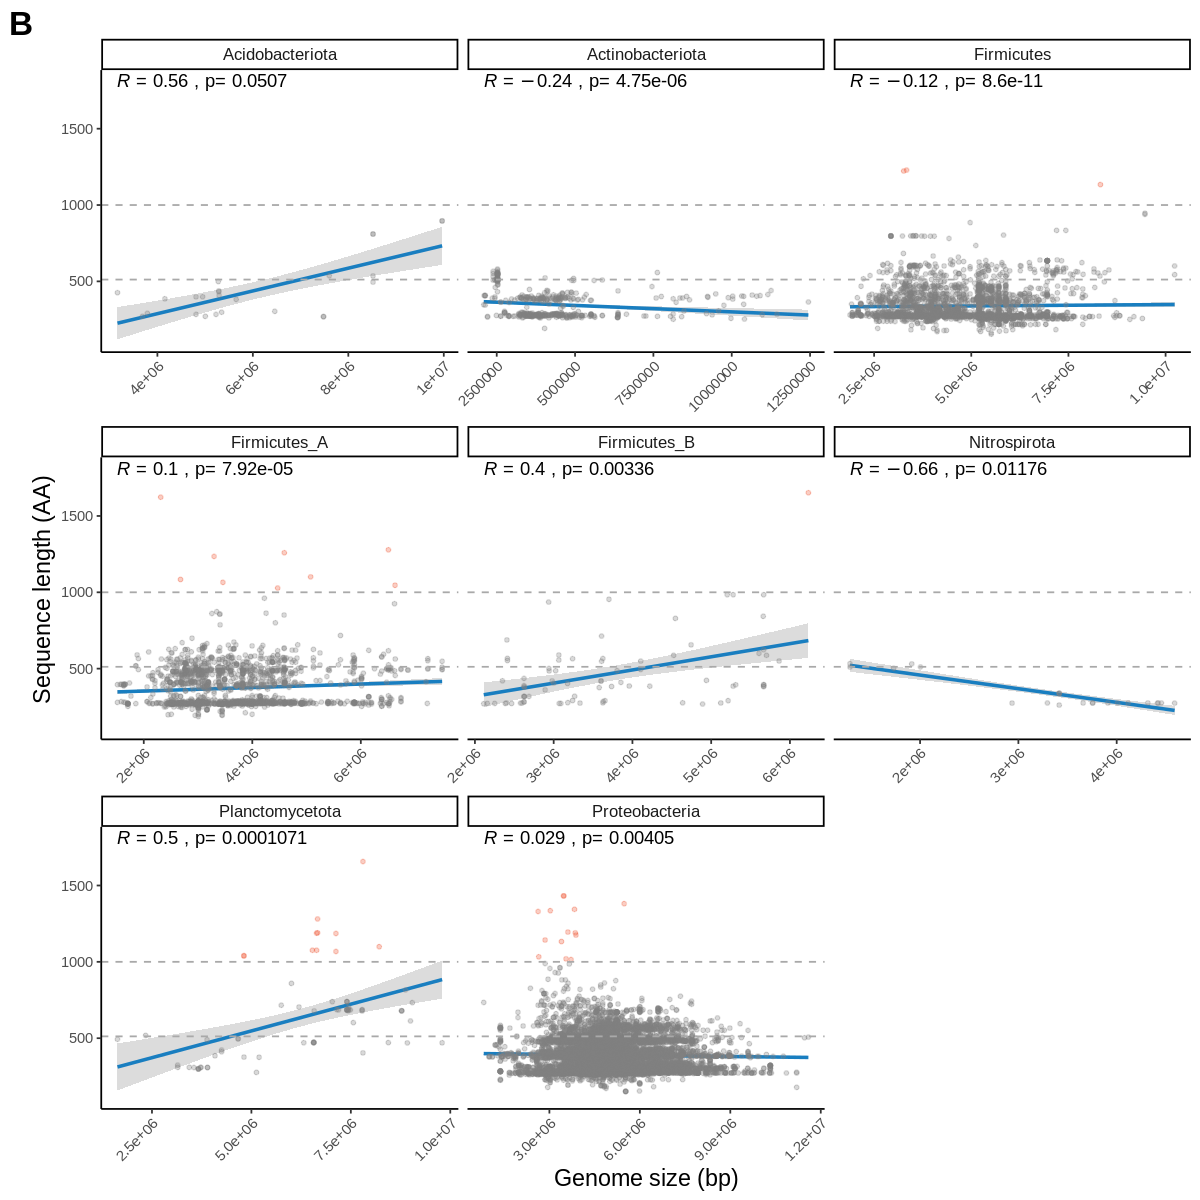

In [583]:
scatter.plot_filtered

In [585]:
lay.2 <- rbind(c(1,1,1,1),
             c(2,2,2,2),
             c(2,2,2,2))
grobs.plots2 = list(plot.length,scatter.plot_filtered)

In [586]:
#file("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures/Figure1.pdf")
pdf(file.path(figures_path,"Figure2_filt.pdf"), width = 12, height = 12)
grid.arrange(grobs = grobs.plots2 , layout_matrix = lay.2 )
dev.off()

png 
  2

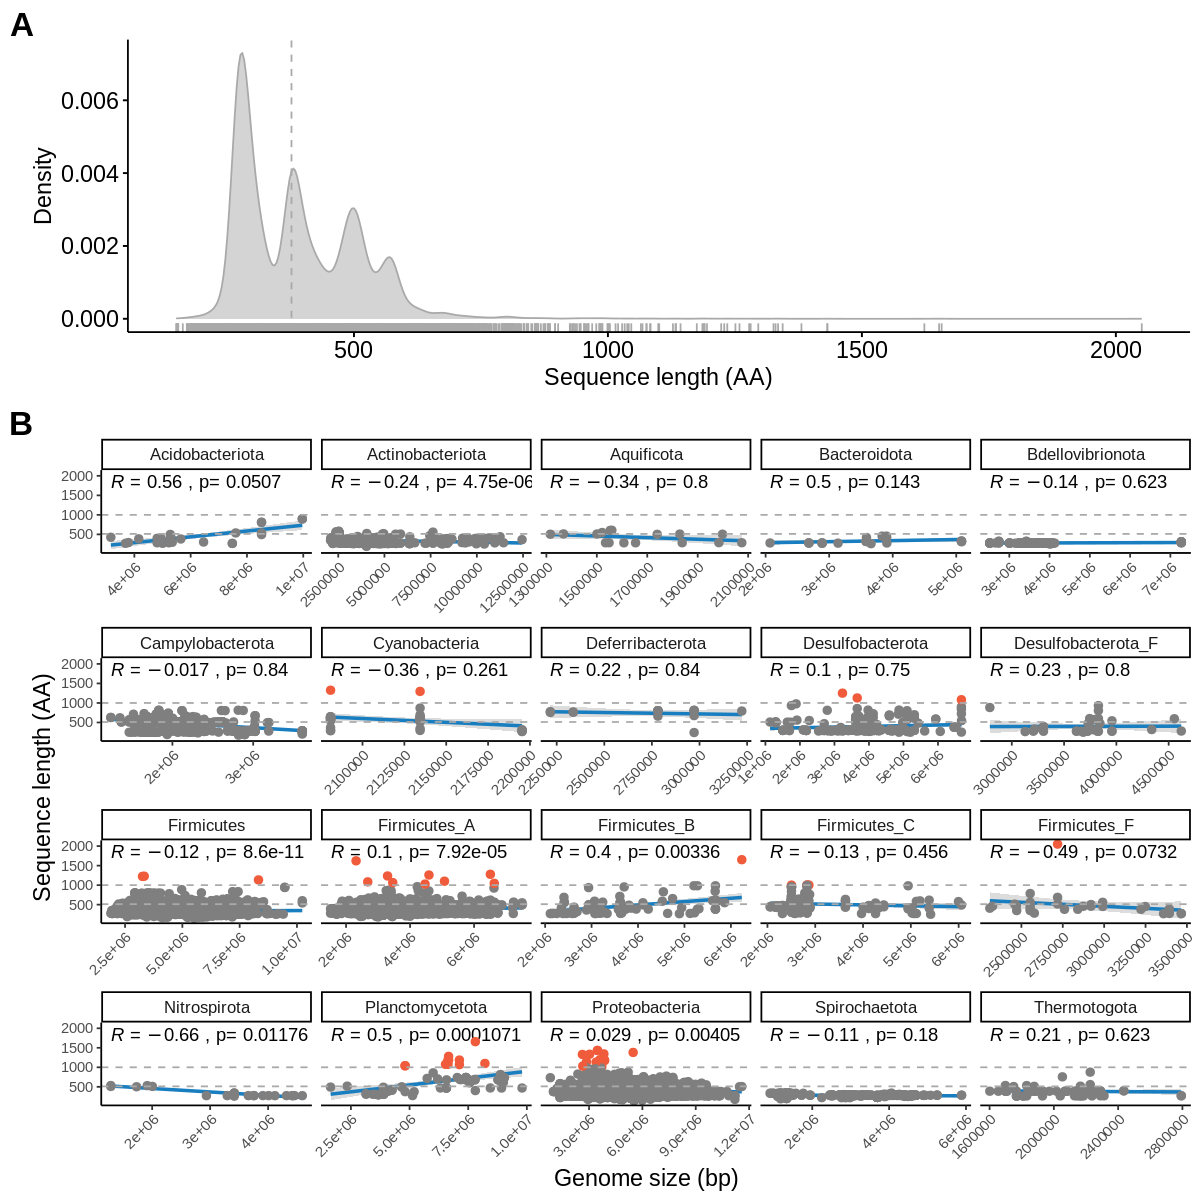

In [540]:
grid.arrange(grobs = grobs.plots2 , layout_matrix = lay.2 )

### Top 3% flagellins

Selecting by n


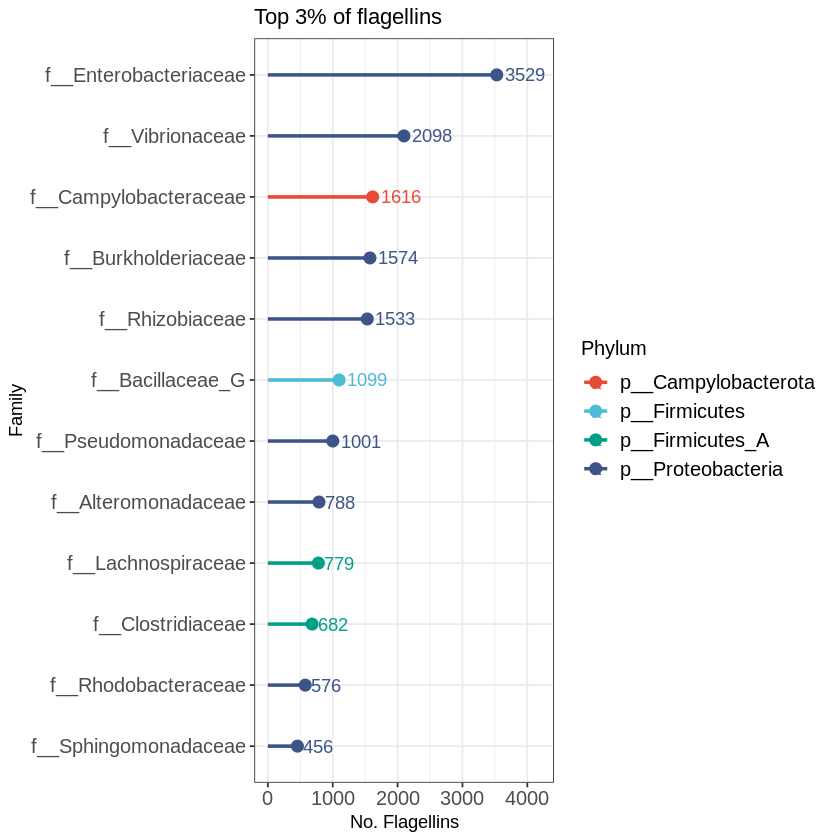

In [25]:
ggplot(filter(sorted.phylum) %>% top_frac(0.03),
                          aes(y=reorder(Family,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Family,xend=0),size=1)+
                        geom_point(size=3)+
                        geom_text(aes(label = n), hjust = -0.2) +
                        xlim(c(0,4200))+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 3% of flagellins")+
                        theme(axis.text.x= element_text(size=12),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )

### Subset most abundant phyla

In [26]:
#Subset Proteobacteria
subset.proteo = filter(full.db.taxonomy.length,Phylum%in%"p__Proteobacteria")
#Subset Firmicutes_A
subset.firm_a = filter(full.db.taxonomy.length,Phylum%in%"p__Firmicutes_A")
#Subset Firmicutes
subset.firm = filter(full.db.taxonomy.length,Phylum%in%"p__Firmicutes")
#Subset Desulfobacterota
subset.desulf = filter(full.db.taxonomy.length,Phylum%in%"p__Desulfobacterota")
#Subset Campylobacterota
subset.campy = filter(full.db.taxonomy.length,Phylum%in%"p__Campylobacterota")
#Subset Actinobacteriota
susbet.actino = filter(full.db.taxonomy.length,Phylum%in%"p__Actinobacteriota")

In [27]:
subset.proteo$group <- "Proteobacteria"
subset.firm_a$group <- "Firmicutes_A"
subset.firm$group <- "Firmicutes"
subset.desulf$group <- "Desulfobacterota"
subset.campy$group <- "Campylobacterota"
susbet.actino$group <- "Actinobacteriota"

combined_data <- rbind(subset.proteo, subset.firm_a, subset.firm, subset.desulf, subset.campy, susbet.actino)

In [464]:
tmp.underMedian = count(full.db.taxonomy.length,Phylum,sort=T) %>%
                    filter(n>14)%>%
                    select(Phylum)

In [468]:
tmp.taxonomy=filter(full.db.taxonomy.length,Phylum%in%tmp.underMedian$Phylum) %>%
            mutate(over1000 = ifelse(seqLength>=1000,TRUE,FALSE))

#### Plot correlations in phyla over the median

In [508]:
ggscatter(data=tmp.taxonomy, x = "genome_size", y = "seqLength",
#         cor.coef = TRUE, cor.method = "spearman",
         xlab = "genome_size", ylab = "seqLength",color = "#075149ff",
         add.params = list(color = "#197ec0ff", fill=  "darkgray"),
         size=1,alpha=0.7,
         add = "reg.line", conf.int = TRUE)+
        stat_cor(aes(label = paste0(..r.label..,
                             "~`,`~`p=`~",
                             p.adjust(readr::parse_number(..p.label..), n = 20))),
                             method = "spearman", label.y = 1800)+
        geom_point(aes(color = over1000),size=2)+
        scale_color_manual(values = c("TRUE" = "#f05c3bff"))+

        geom_hline(yintercept=1000, color="darkgray", size=0.5, linetype="dashed")+
        geom_hline(yintercept=512, color="darkgray", size=0.5, linetype="dashed")+ #why this number?
        facet_wrap(~Phylum, scales = "free_x")+
        
        theme_classic()+
        theme(
            axis.title = element_text(size=14),
            axis.text.x = element_text(angle = 45, hjust = 1),  # Improve axis text readability
            strip.text.x = element_text(size = 10),  # Adjust facet label size
            plot.title = element_text(size = 14, face = "bold"),  # Customize titles
            legend.position = "none"
    )+
        xlab("Genome size (bp)")+
        ylab("Sequence length (AA)")



#### Plot correlations in the most abundant phyla

In [65]:
ggscatter(data=combined_data, x = "genome_size", y = "seqLength",
         add = "reg.line", 
         conf.int = TRUE,
         cor.coef = TRUE, 
         cor.method = "spearman",
         add.params = list(color = "darkred",
                               fill=  "lightgray"),
         xlab = "genome_size", ylab = "seqLength",color = "darkgray")+
    
    facet_wrap(~Phylum, scales = "free_x")+
    theme_classic() +  # Base theme
    labs(
        title = "Relationship between Genome Size and Sequence Length by Phylum",
        x = "Genome Size",
        y = "Sequence Length"
    ) +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1),  # Improve axis text readability
        strip.text.x = element_text(size = 10),  # Adjust facet label size
        plot.title = element_text(size = 14, face = "bold"),  # Customize titles
        legend.position = "bottom"
    )

### Correlation seqLen and genome size + taxonomy

In [71]:
library(GGally)

# Scatterplot matrix
ggpairs(subset.firm_a, columns = c("Class", "seqLength", "genome_size"), aes(fill=Class),
        lower = list(continuous = "points", combo = "dot"), 
        diag = list(continuous = "density", combo = "bar",alpha=0.6), 
        title = "Pairwise Relationships among Phylum, Length, and Genome Size") + 
        #scale_fill_manual(values = phylum_colors)+ 
  scale_size_area() +
  theme(axis.text.x = element_text(size = 12,angle=45,hjust=1),
        axis.text.y = element_text(size = 12),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        strip.text = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        panel.spacing = unit(0.4, "cm"))


Warning message in check_and_set_ggpairs_defaults("diag", diag, continuous = "densityDiag", :
“Changing diag$continuous from 'density' to 'densityDiag'”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


Selecting by n


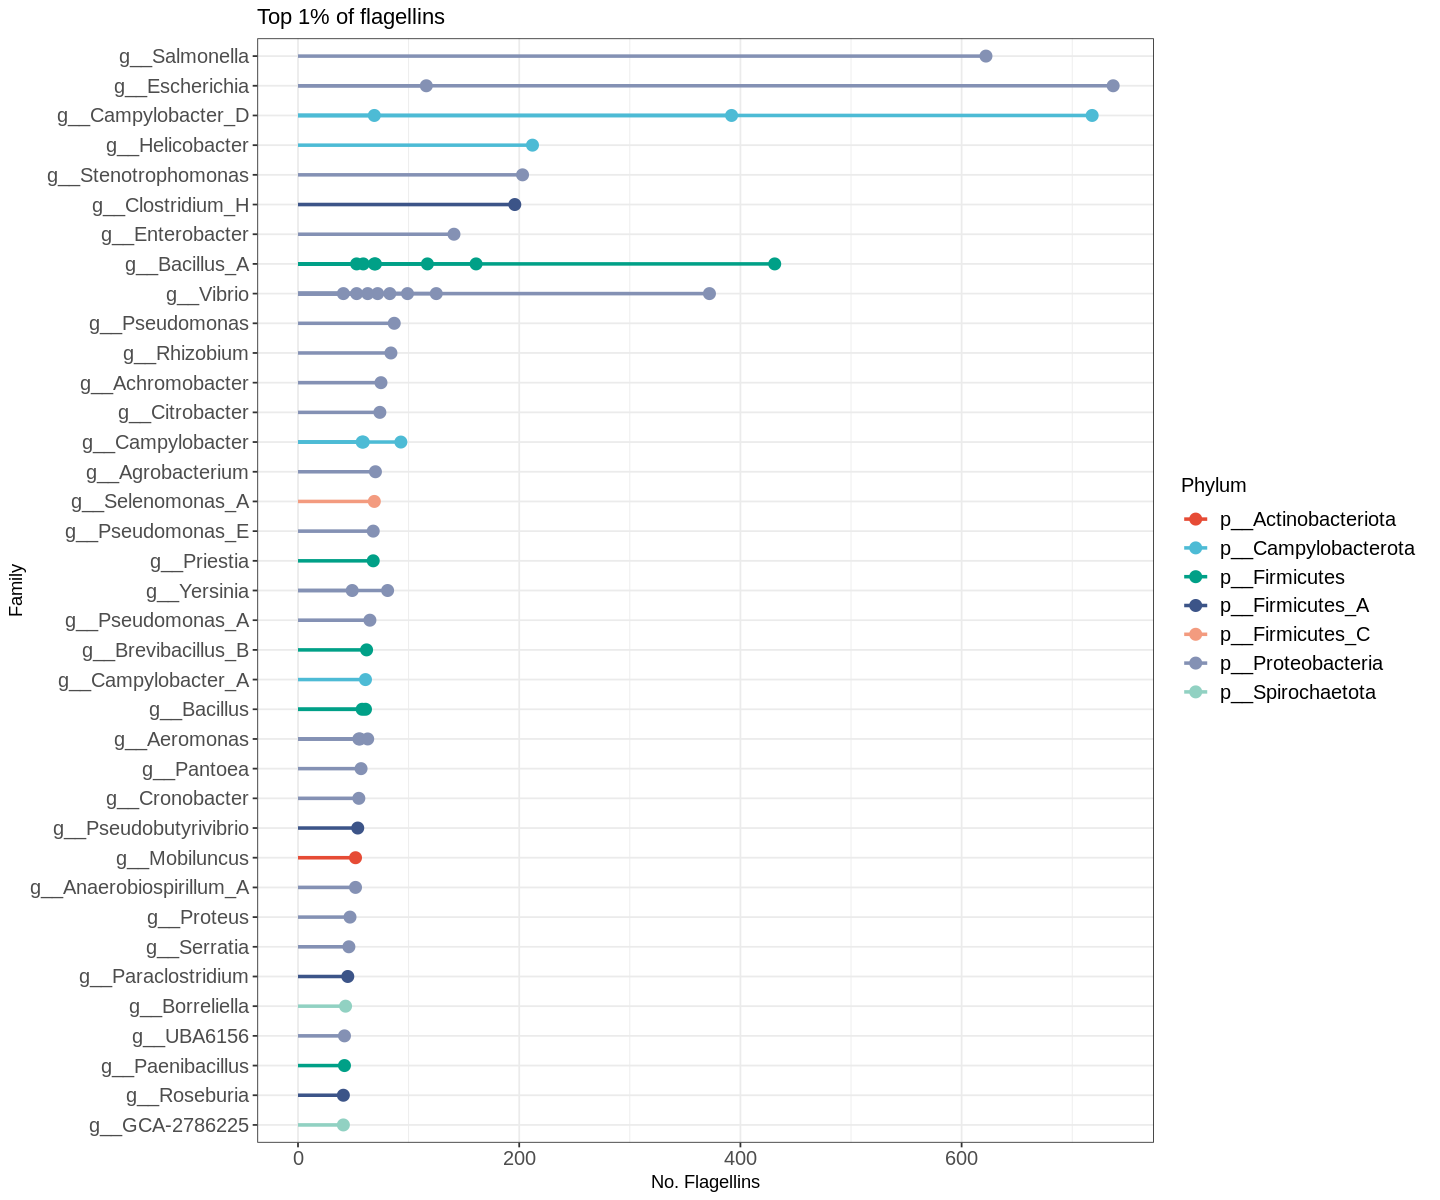

In [72]:
#top.1 = filter(sorted.per.phylum) %>% top_frac(0.01)
ggplot(filter(count.taxonomy.fulldb) %>% top_frac(0.01),aes(y=reorder(Genus,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Genus,xend=0),size=1)+
                        geom_point(size=3)+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 1% of flagellins")+
                        theme(axis.text.x= element_text(size=12),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )
                        
                        

Selecting by n


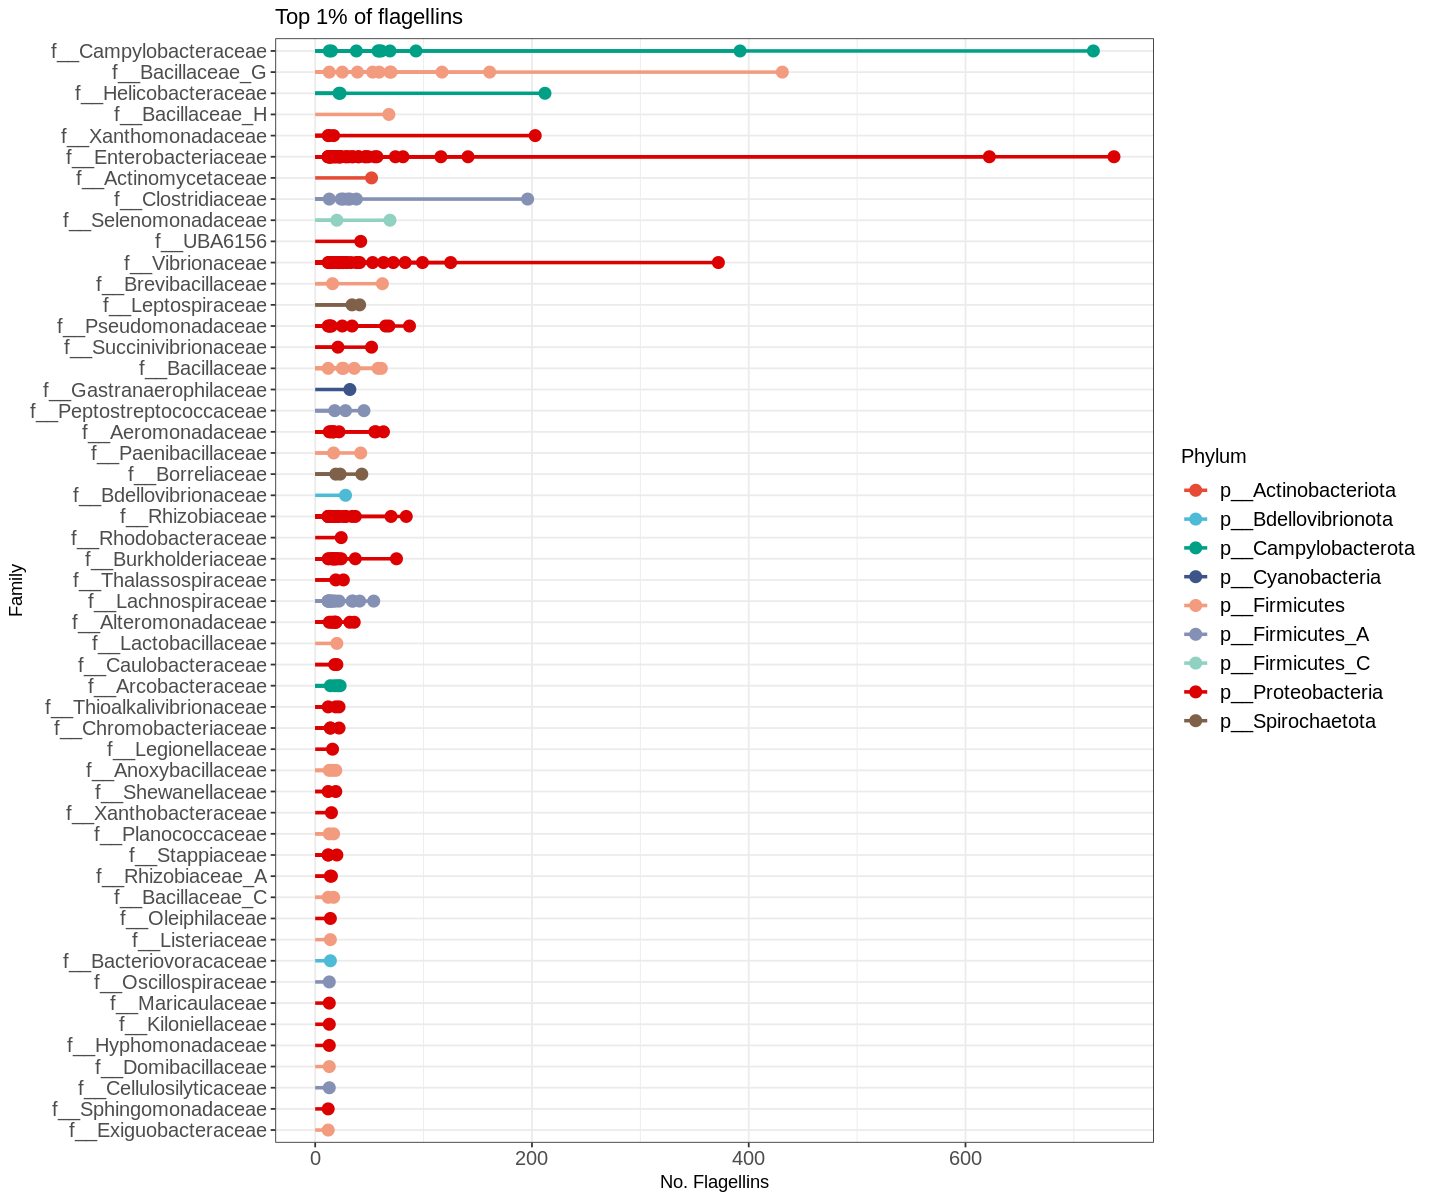

In [73]:
#top.1 = filter(sorted.per.phylum) %>% top_frac(0.01)
#top50 = top_n(count.taxonomy.fulldb$n*0.5)
ggplot(filter(count.taxonomy.fulldb) %>% top_n(sum(count.taxonomy.fulldb$n)*0.01),aes(y=reorder(Family,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Family,xend=0),size=1)+
                        geom_point(size=3)+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 1% of flagellins")+
                        theme(axis.text.x= element_text(size=12),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )
                        
                        

### Procrustes analysis between gene tree and taxonomy

In [ ]:
fulldb.tre = read_tree("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/flagellin_phylogeny/curatedflab.with.outgroup.tre")

In [ ]:
dist_genetic = cophenetic(all.tre)

In [ ]:
head(dist_genetic)

In [ ]:
taxa_numeric = select(fla.taxonomy.length,c(Accession,Phylum,Class,Order,Family,Genus,Species))

In [ ]:
head(taxa_numeric)

In [ ]:
ggplot(fulldb.tre) + geom_tree() + theme_tree()

# Shortbred flagellins

### Import flagellin sequences

In [74]:
flagellins.markers.sb=seqinr::read.fasta("/ebio/abt3_projects/small_projects/aborbon/Thesis_FlagellinDiversity/1_shortbred/out.finalmap.faa",seqtype="AA")

In [75]:
#Get HVR length across sequences
length.seqs=as_tibble(getName(flagellins.markers.sb))%>%
            mutate(length=getLength(flagellins.markers.sb))%>%
            mutate(HVR_length=length-240)%>%
            rename(Accession="value")

In [77]:
nrow(length.seqs)

[1] 9963

In [78]:
fla.taxonomy.length=inner_join(length.seqs,taxonomy.full.db,by="Accession")%>%
select(c(contains(c("genome","assembly")),"Accession","length","HVR_length","ncbi_taxid","ncbi_phylum","genome_size","Domain","Phylum","Class","Order","Family","Genus","Species"))

In [99]:
count_phylum.tmp = count(fla.taxonomy.length,Phylum,sort=TRUE)

In [100]:
#descriptive stats
data.frame(
    "statistic" = c("median","MAD","IQR","mean","SD"),
    "value" = c(median(count_phylum.tmp$n), 
              mad(count_phylum.tmp$n),
              IQR(count_phylum.tmp$n),
              mean(count_phylum.tmp$n),
              sd(count_phylum.tmp$n))
    )

statistic value   
1 median      8.0000
2 MAD        10.3782
3 IQR        27.0000
4 mean      163.3279
5 SD        748.6603

### Plot genome size, sequence length 

In [105]:
tmp.underMedian.sb = count(fla.taxonomy.length,Phylum,sort=T) %>%
                    filter(n>14)%>%
                    select(Phylum)

In [106]:
tmp.taxonom.sb=filter(fla.taxonomy.length,Phylum%in%tmp.underMedian.sb$Phylum)

In [107]:
ggscatter(data=tmp.taxonom.sb, x = "genome_size", y = "length",
         add = "reg.line", conf.int = TRUE,
         cor.coef = TRUE, cor.method = "spearman",
         xlab = "genome_size", ylab = "seqLength",
         add.params = list(color = "darkred",
                               fill=  "lightgray"),
         size=0.7,alpha=0.6)+
geom_hline(yintercept=1000, color="darkgray", size=0.5, linetype="dashed")+
geom_hline(yintercept=512, color="darkgray", size=0.5, linetype="dashed")+
geom_point(size=0.6,alpha=0.4)+
facet_wrap(~Phylum, scales = "free_x")+
theme_classic()+
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1),  # Improve axis text readability
        strip.text.x = element_text(size = 10),  # Adjust facet label size
        plot.title = element_text(size = 14, face = "bold"),  # Customize titles
        legend.position = "bottom"
    )

In [81]:
filter(fla.taxonomy.length,length<180)

genome_size gtdb_genome_representative ncbi_genome_category
1 4362047     RS_GCF_002287375.1         none                
2 5513190     RS_GCF_001583695.1         none                
3 4295882     RS_GCF_002157855.1         none                
4 5240711     RS_GCF_000971965.1         none                
5 2943210     RS_GCF_000225005.1         none                
6 3871245     RS_GCF_900114405.1         none                
  ncbi_genome_representation ncbi_assembly_level
1 full                       Contig             
2 full                       Scaffold           
3 full                       Complete Genome    
4 full                       Scaffold           
5 full                       Contig             
6 full                       Scaffold           
  ncbi_assembly_name                      ncbi_assembly_type
1 ASM228737v1                             na                
2 ASM220021v1                             na                
3 ASM215785v1                             na                
4 ASM97196v1                              na                
5 PHS-1-454                               na                
6 IMG-taxon 2654588176 annotated assembly na                
  ncbi_genbank_assembly_accession Accession      length HVR_length ncbi_taxid
1 GCA_002287375.1                 WP_095654077.1 179    -61        2024555   
2 GCA_002200215.1                 PEM23444.1     154    -86        1890302   
3 GCA_002157855.1                 WP_064097877.1 178    -62          79883   
4 GCA_000971965.1                 WP_046212871.1 172    -68        1567107   
5 GCA_000225005.2                 EHQ51648.1     178    -62         519989   
6 GCA_900114405.1                 SFL40111.1     172    -68        1855374   
  ncbi_phylum    Domain      Phylum            Class                 
1 Firmicutes     d__Bacteria p__Firmicutes     c__Bacilli            
2 Firmicutes     d__Bacteria p__Firmicutes     c__Bacilli            
3 Firmicutes     d__Bacteria p__Firmicutes     c__Bacilli            
4 Firmicutes     d__Bacteria p__Firmicutes     c__Bacilli            
5 Proteobacteria d__Bacteria p__Proteobacteria c__Gammaproteobacteria
6 Firmicutes     d__Bacteria p__Firmicutes_A   c__Clostridia         
  Order                    Family                    Genus                
1 o__Bacillales_D          f__Amphibacillaceae       g__Virgibacillus_G   
2 o__Bacillales            f__Bacillaceae_G          g__Bacillus_A        
3 o__Bacillales            f__Bacillaceae_I          g__Sutcliffiella     
4 o__Paenibacillales       f__Paenibacillaceae       g__Paenibacillus_J   
5 o__Ectothiorhodospirales f__Ectothiorhodospiraceae g__Ectothiorhodospira
6 o__Lachnospirales        f__Lachnospiraceae        g__NK4A144           
  Species                          
1 s__Virgibacillus_G profundi      
2 s__Bacillus_A wiedmannii         
3 s__Sutcliffiella horikoshii_C    
4 s__Paenibacillus_J wulumuqiensis 
5 s__Ectothiorhodospira sp000225005
6 s__NK4A144 sp900114405

In [82]:
ggplot(data=fla.taxonomy.length, aes(x=length)) +
  geom_histogram(binwidth=20, alpha=0.8, color="white") +
  theme_bw(base_size=18) +
  labs(x="Sequence length", y="Count", title="Distribution of sequence lengths") +
  theme(axis.title=element_text(size=20), plot.title=element_text(size=24, face="bold")) +
#geom_vline(xintercept=median(fla.taxonomy.length$length), color="orange", size=1, linetype="dashed") +

geom_vline(xintercept=mean(fla.taxonomy.length$length), color="steelblue", size=1, linetype="dashed") +
annotate("text", x=mean(fla.taxonomy.length$length), y=12, label=paste("Mean: ", round(mean(fla.taxonomy.length$length), 0)), hjust=-5.1,vjust=1.5,angle=90, color="steelblue") +
  
 
geom_vline(xintercept=min(fla.taxonomy.length$length), color="red", size=1, linetype="dashed") +
annotate("text", x=min(fla.taxonomy.length$length), y=12, label=paste("Min: ", round(min(fla.taxonomy.length$length), 0)), hjust=-7,vjust=1.5,angle=90, color="red") +

geom_vline(xintercept=max(fla.taxonomy.length$length), color="purple", size=1, linetype="dashed")+
annotate("text", x=mean(fla.taxonomy.length$length), y=12, label=paste("Max: ", round(max(fla.taxonomy.length$length), 0)), hjust=-6,vjust=44,angle=90, color="purple")

### Per phylum counts

In [83]:
count.per.phylum=count(fla.taxonomy.length,Phylum,sort=TRUE,.drop=FALSE)%>%
                    mutate(Phylum=str_remove_all(Phylum,"p__"))

In [84]:
head(count.per.phylum)

Phylum           n   
1 Proteobacteria   5637
2 Firmicutes       1361
3 Firmicutes_A     1167
4 Actinobacteriota  304
5 Campylobacterota  280
6 Desulfobacterota  142

In [85]:
sorted.per.phylum = count(fla.taxonomy.length,Phylum,Family,sort=TRUE,.drop=FALSE)%>%
                    mutate(Phylum=str_remove_all(Phylum,"p__"))%>%
                    mutate(Family=str_remove_all(Family,"f__"))

In [86]:
head(sorted.per.phylum)

Phylum         Family             n  
1 Proteobacteria Burkholderiaceae   752
2 Proteobacteria Enterobacteriaceae 653
3 Firmicutes_A   Lachnospiraceae    549
4 Proteobacteria Rhizobiaceae       445
5 Proteobacteria Rhodobacteraceae   430
6 Proteobacteria Pseudomonadaceae   343

#### Top 10% of phyla

Selecting by n


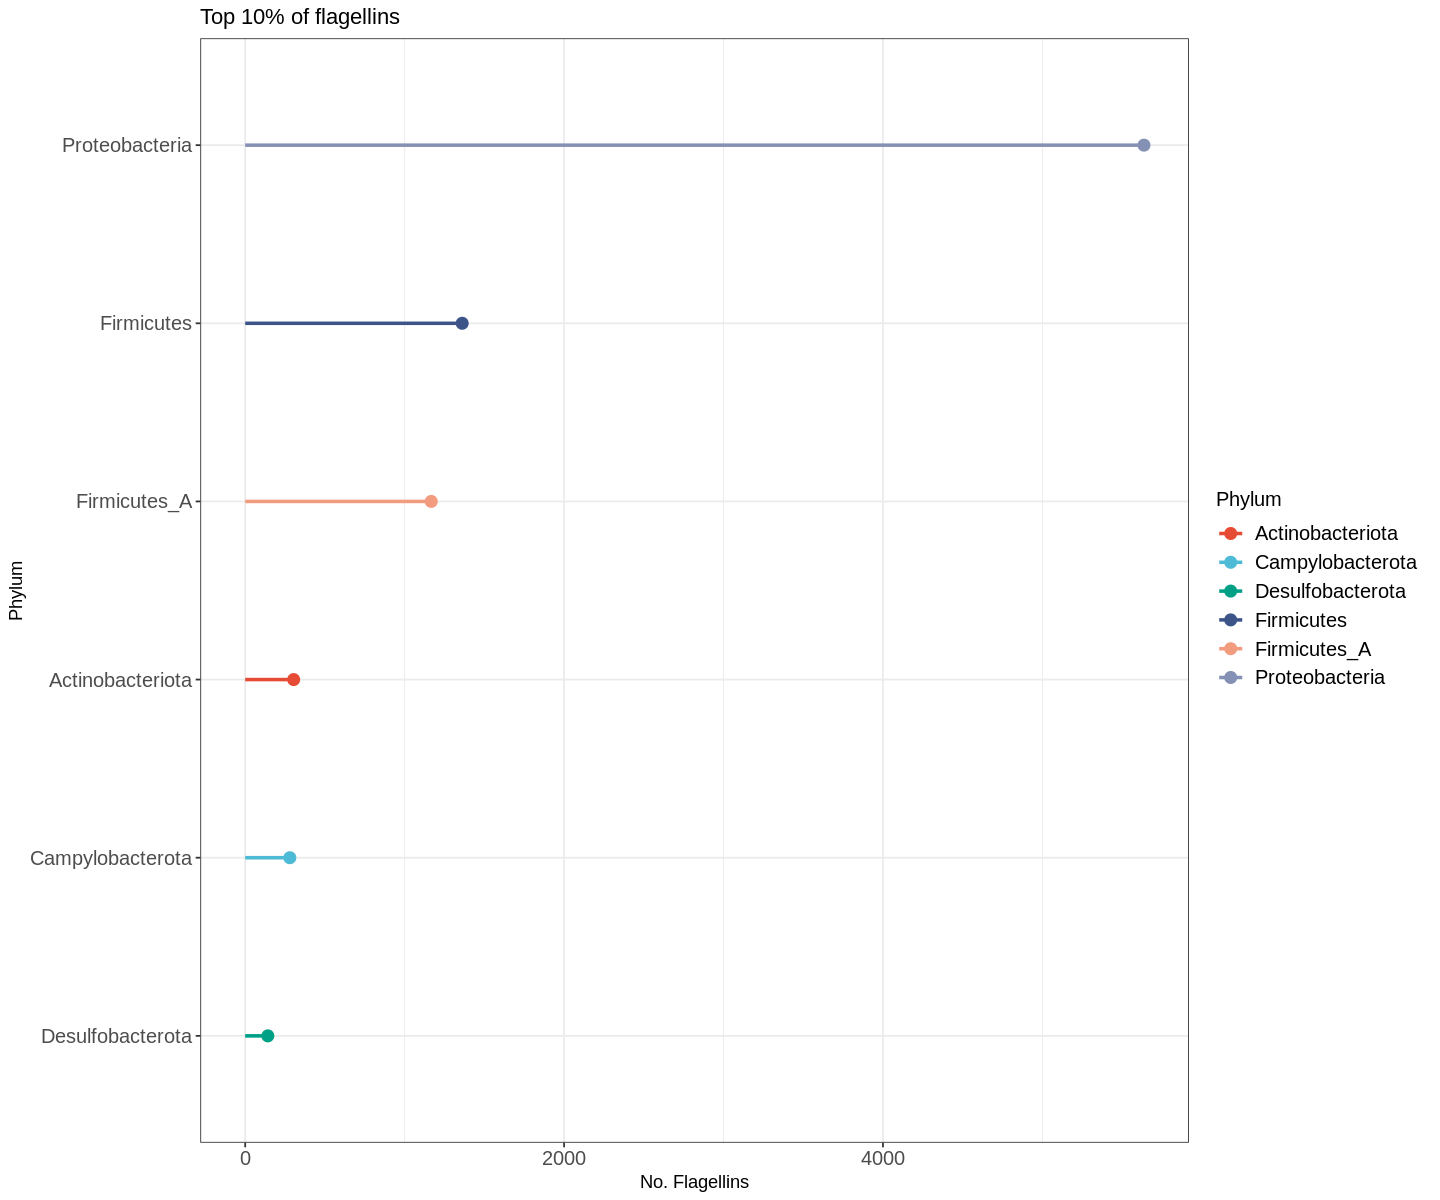

In [87]:
top.10.phylum = filter(count.per.phylum) %>% top_frac(0.1)
ggplot(top.10.phylum,aes(y=reorder(Phylum,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Phylum,xend=0),size=1)+
                        geom_point(size=3)+
                        labs(x="No. Flagellins",y="Phylum")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 10% of flagellins")+
                        theme(axis.text.x= element_text(size=12),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )
                        

#### Top 1% of Family

In [88]:
top.1 = filter(sorted.per.phylum) %>% top_frac(0.01)
ranked.fla.top.1 = ggplot(top.1,aes(y=reorder(Family,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Family,xend=0),size=1)+
                        geom_point(size=3)+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 1% of flagellins")+
                        theme(axis.text.x= element_text(size=12),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )
                        
                        
ranked.fla.top.1

Selecting by n


#### Top 3% of Family

In [108]:
top.3 = filter(sorted.per.phylum) %>% top_frac(0.03)
ranked.fla.top.3 = ggplot(top.3,aes(y=reorder(Family,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Family,xend=0),size=1)+
                        geom_point(size=3)+
                        geom_text(aes(label = n), hjust = -0.2) +
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 3% of flagellins")+
                        theme(axis.text.x= element_text(size=12),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )
                        
                        
ranked.fla.top.3

Selecting by n


#### Top 5% of Family

Selecting by n


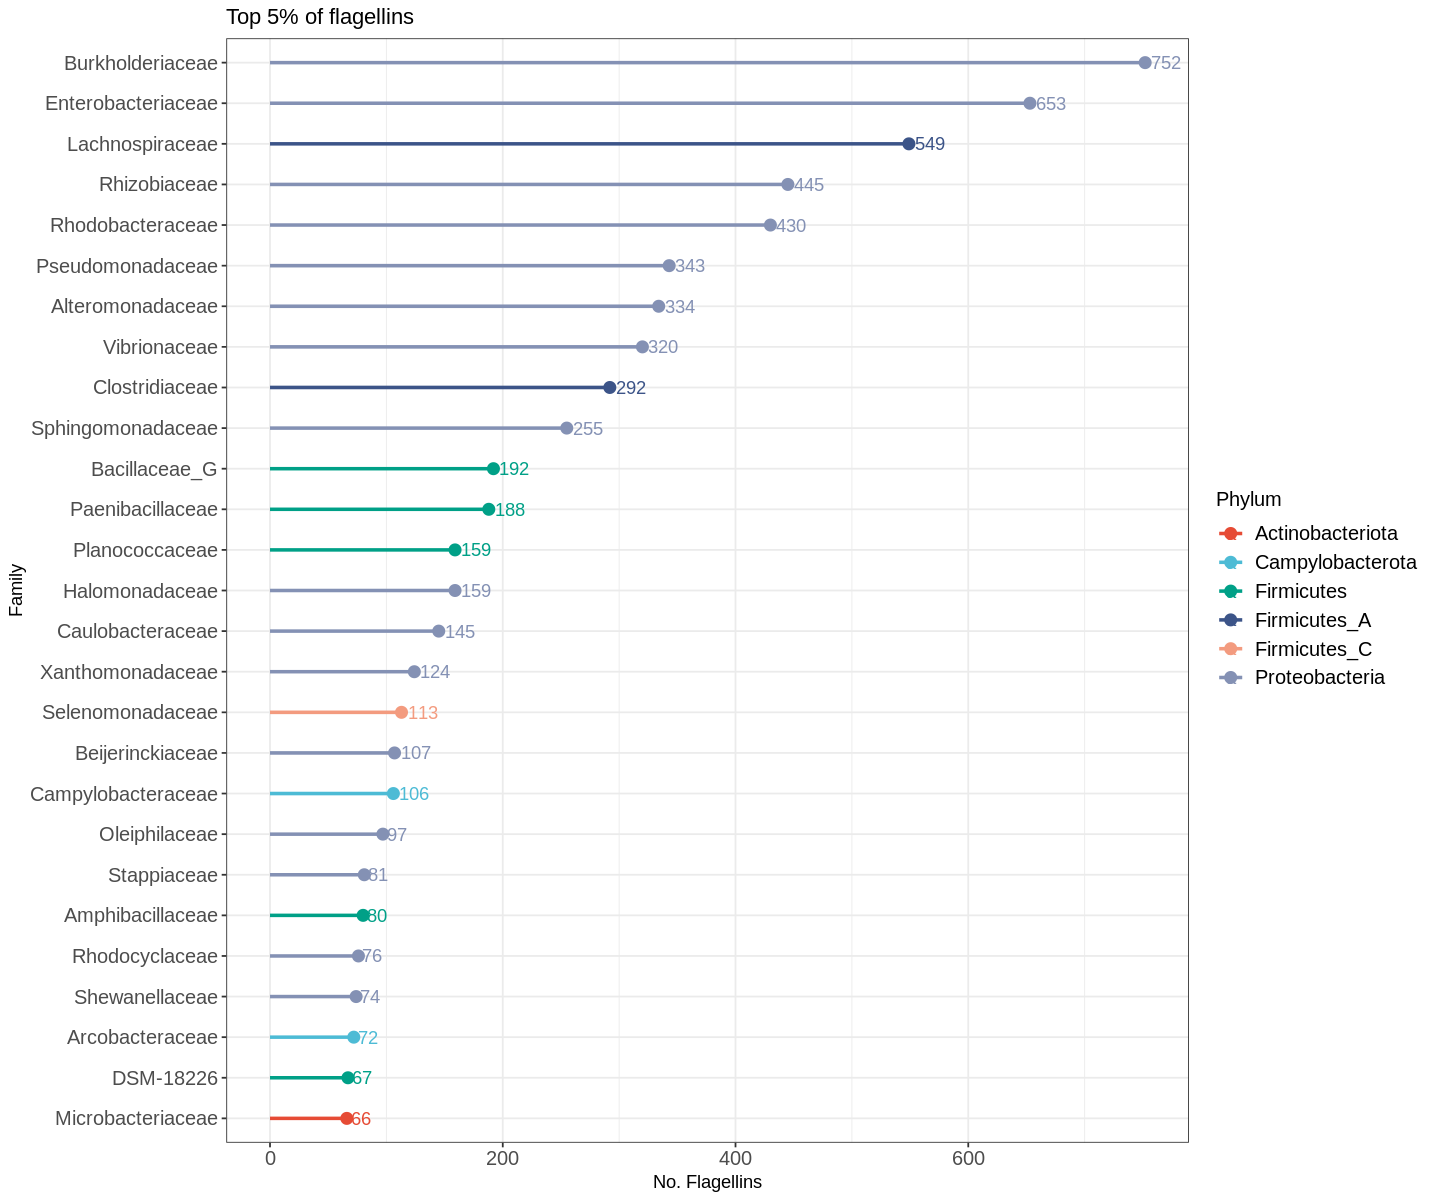

In [109]:
top.5 = filter(sorted.per.phylum) %>% top_frac(0.05)
ranked.fla.top.5 = ggplot(top.5,aes(y=reorder(Family,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Family,xend=0),size=1)+
                        geom_point(size=3)+
                        geom_text(aes(label = n), hjust = -0.2)+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 5% of flagellins")+
                        theme(axis.text.x= element_text(size=12),
                             axis.text.y=element_text(size=12),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )
                        
                        
ranked.fla.top.5

#### Top 10% of Family

Selecting by n


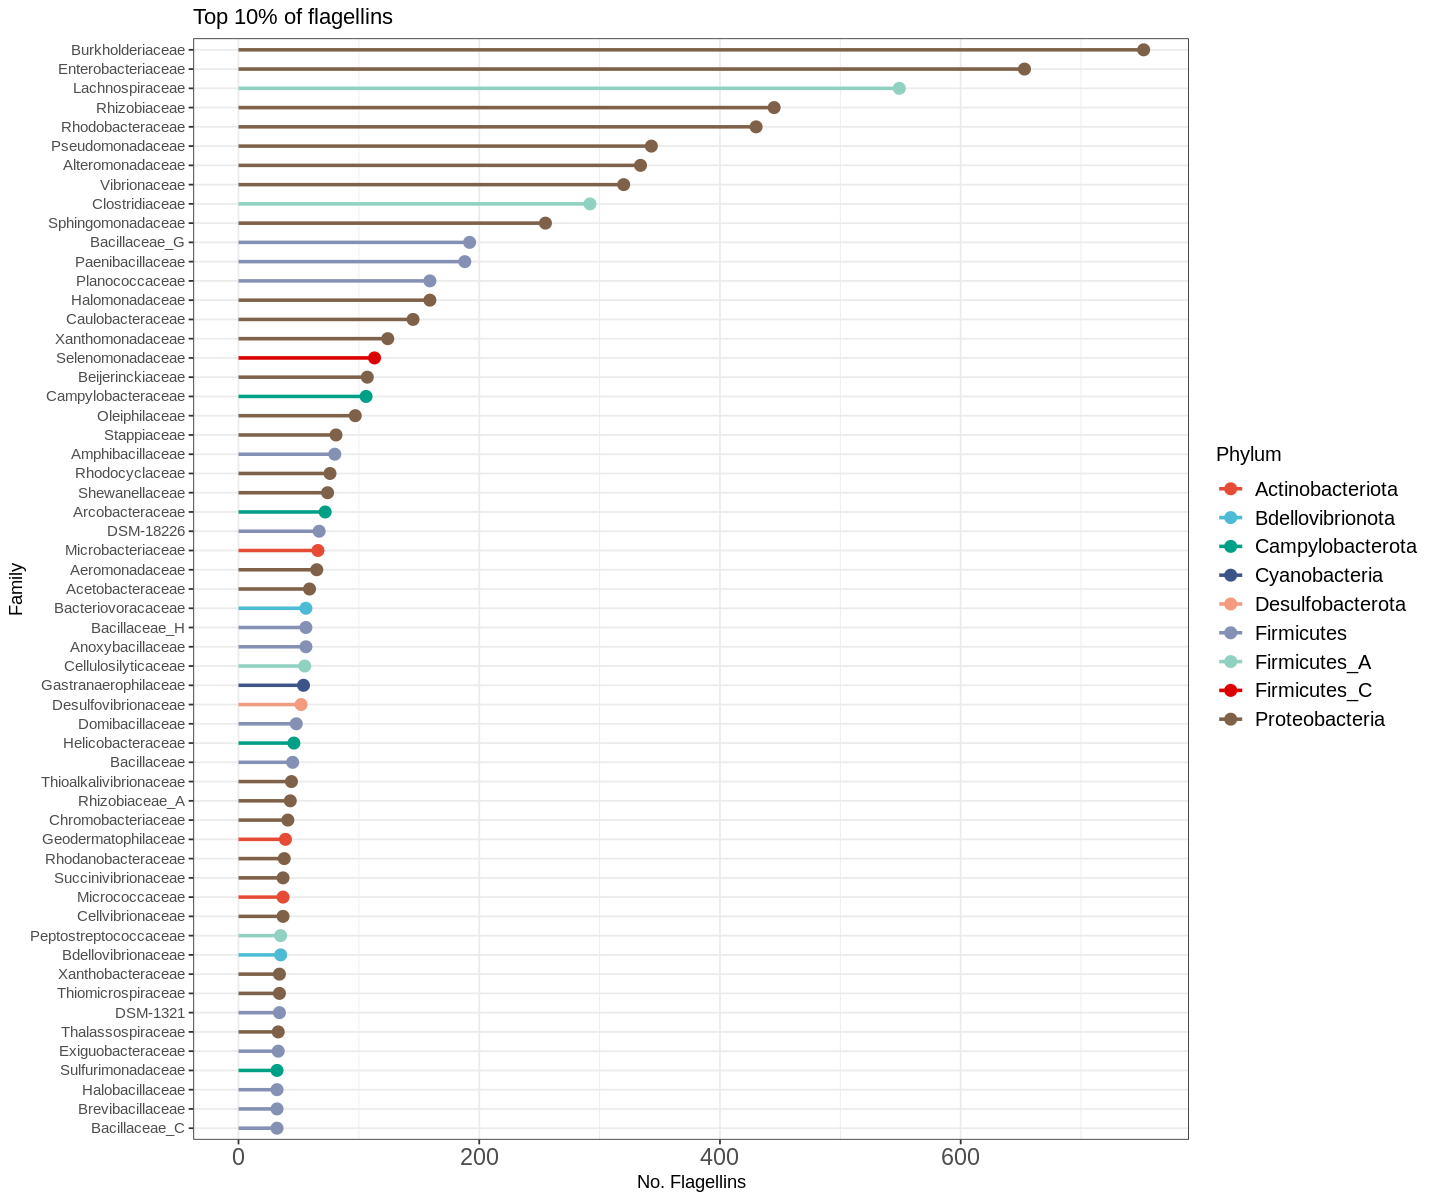

In [110]:
top.10 = filter(sorted.per.phylum) %>% top_frac(0.1)
ranked.fla.top.10 = ggplot(top.10,aes(y=reorder(Family,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Family,xend=0),size=1)+
                        geom_point(size=3)+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 10% of flagellins")+
                        theme(axis.text.x= element_text(size=14),
                             axis.text.y=element_text(size=9),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )
                        
ranked.fla.top.10

#### Flagellin counts per Genus

In [111]:
count.per.genus = count(fla.taxonomy.length,Genus,Phylum,sort=TRUE)

In [112]:
head(count.per.genus)

Genus                Phylum            n  
1 g__Pseudomonas_E     p__Proteobacteria 193
2 g__Vibrio            p__Proteobacteria 190
3 g__Bacillus_A        p__Firmicutes     187
4 g__Pseudoalteromonas p__Proteobacteria 112
5 g__Clostridium       p__Firmicutes_A   105
6 g__Sphingomonas      p__Proteobacteria 102

In [113]:
#top_n(count.per.genus,n=100)
ggplot(data=top_n(count.per.genus,n=80),aes(x=n,fill=Phylum))+
     geom_density(alpha=0.7)

Selecting by n
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


In [114]:
top.10.genus = filter(count.per.genus) %>% top_frac(0.03)
ggplot(top.10.genus,aes(y=reorder(Genus,n,descending=TRUE),x=n,color=Phylum))+
                        geom_segment(aes(yend=Genus,xend=0),size=1)+
                        geom_point(size=3)+
                        labs(x="No. Flagellins",y="Genus")+
                        scale_color_npg()+
                        theme_bw()+
                        ggtitle("Top 3% of Genera")+
                        theme(axis.text.x= element_text(size=14),
                             axis.text.y=element_text(size=9),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )

Selecting by n


#### Flagellin counts in Lachnospiraceae

In [115]:
count.lachno = count(fla.taxonomy.length,Family,Genus,sort = TRUE)%>%
filter(Family == "f__Lachnospiraceae")

Selecting by n


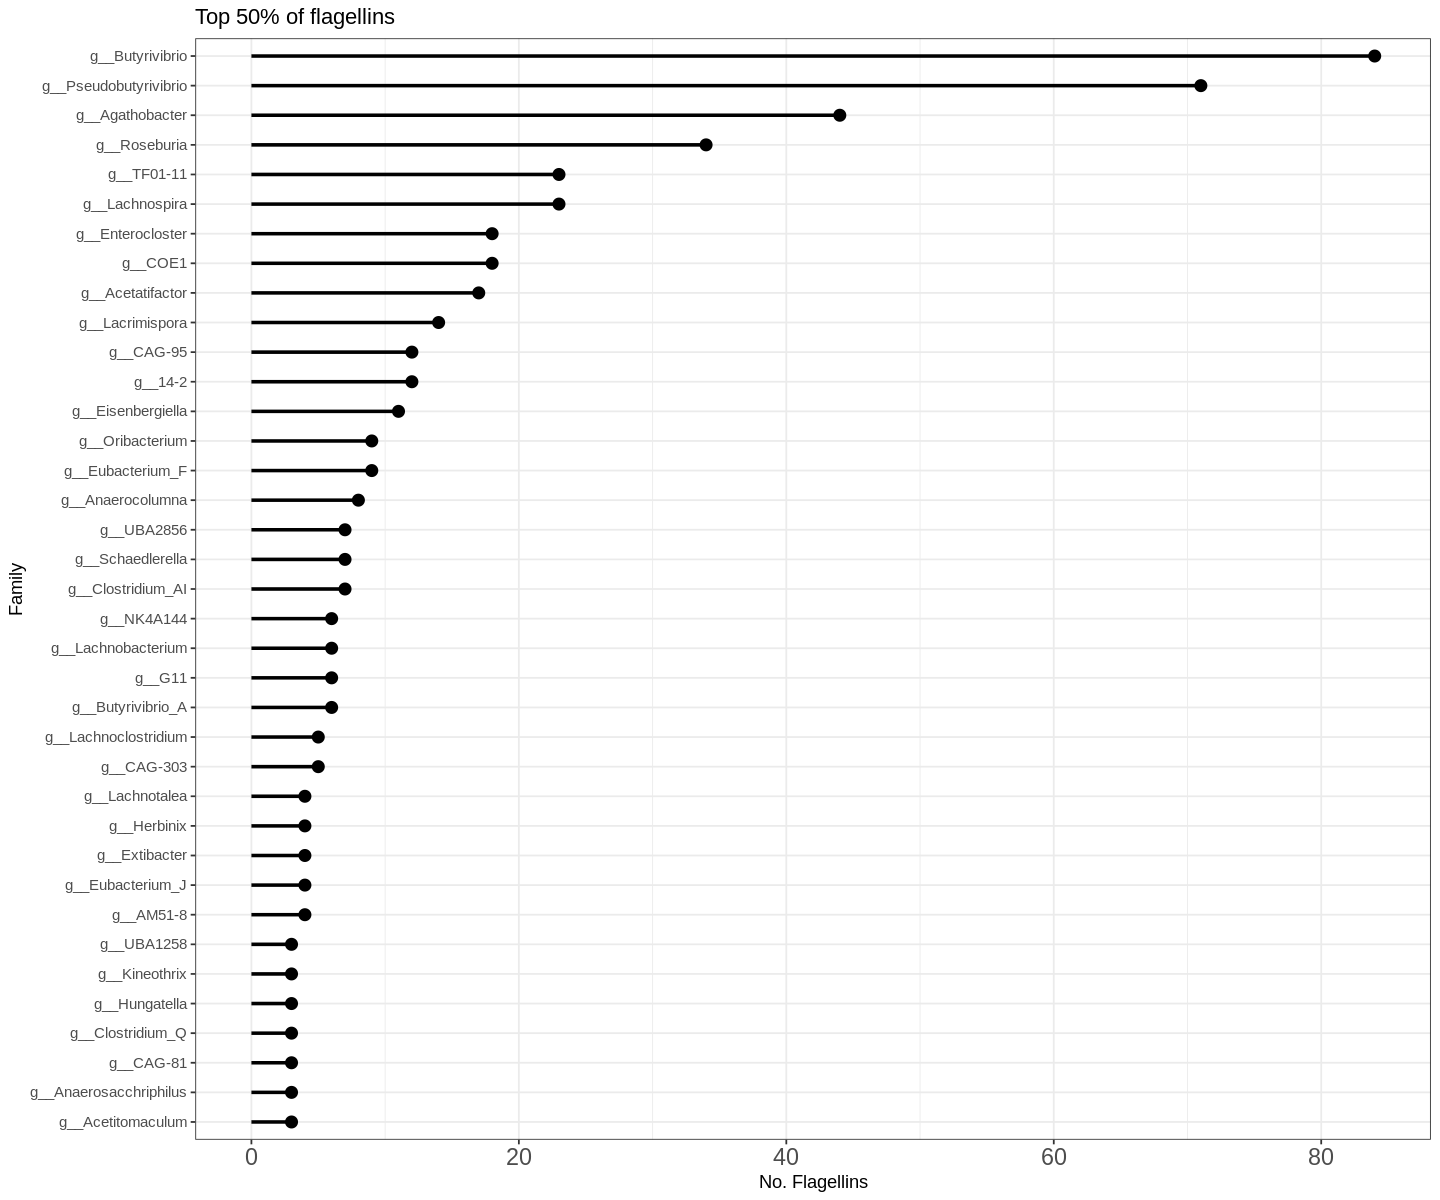

In [116]:
top.lachno = top_frac(count.lachno,0.5)
ggplot(top.lachno,aes(y=reorder(Genus,n,descending=TRUE),x=n),color=Family)+
                        geom_segment(aes(yend=Genus,xend=0),size=1)+
                        geom_point(size=3)+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        guides(scale="none")+
                        theme_bw()+
                        ggtitle("Top 50% of flagellins")+
                        theme(axis.text.x= element_text(size=14),
                             axis.text.y=element_text(size=9),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )

In [117]:
top.10.phylum

Phylum           n   
1 Proteobacteria   5637
2 Firmicutes       1361
3 Firmicutes_A     1167
4 Actinobacteriota  304
5 Campylobacterota  280
6 Desulfobacterota  142

#### Scatterplot matrix for phylum, seqLength and genomeSize

In [118]:
top.10.phylum = filter(count.per.phylum) %>% top_frac(0.1)
#top.10.phylum = filter(count.per.phylum) %>% top_n(10)

Selecting by n


In [119]:
fla.taxonomy.length.top10 = fla.taxonomy.length %>%
    mutate(Phylum=str_remove_all(Phylum,"p__"))%>%
    filter(Phylum %in% top.10.phylum$Phylum)

In [120]:
count.top.phylum = count(fla.taxonomy.length.top10,Phylum,sort=TRUE)
count.top.phylum

Phylum           n   
1 Proteobacteria   5637
2 Firmicutes       1361
3 Firmicutes_A     1167
4 Actinobacteriota  304
5 Campylobacterota  280
6 Desulfobacterota  142

In [121]:
library(randomcoloR)

In [122]:
distinctColorPalette(k = 10, altCol = FALSE, runTsne = FALSE)

[1] "#879FD5" "#DAC9CD" "#DE975C" "#79D3D1" "#CD86D5" "#DE658E" "#CBDDA7"
 [8] "#74E295" "#C0E14F" "#A64CDC"

In [123]:
phylum_colors = c("Actinobacteriota"='#86E09D',
                 "Campylobacterota"='#D3D4C2',
                 "Desulfobacterota"='#DC4EC8',
                 "Firmicutes"='#95E64F',
                 "Firmicutes_A"='#C18AD4',
                 "Proteobacteria"='#7AD7DA')

In [124]:
phylum_colors = c("Actinobacteriota"='#9690DA',
                 "Campylobacterota"='#D7AFCB',
                 "Desulfobacterota"='#96E650',
                 "Firmicutes"='#804CE1',
                 "Firmicutes_A"='#DDCF6C',
                 "Proteobacteria"='#7FDFA0',
                 "Bdellovibrionota" ='#D0D9C0',
                 "Firmicutes_C"='#DA5AC9')

Warning message in check_and_set_ggpairs_defaults("diag", diag, continuous = "densityDiag", :
“Changing diag$continuous from 'density' to 'densityDiag'”


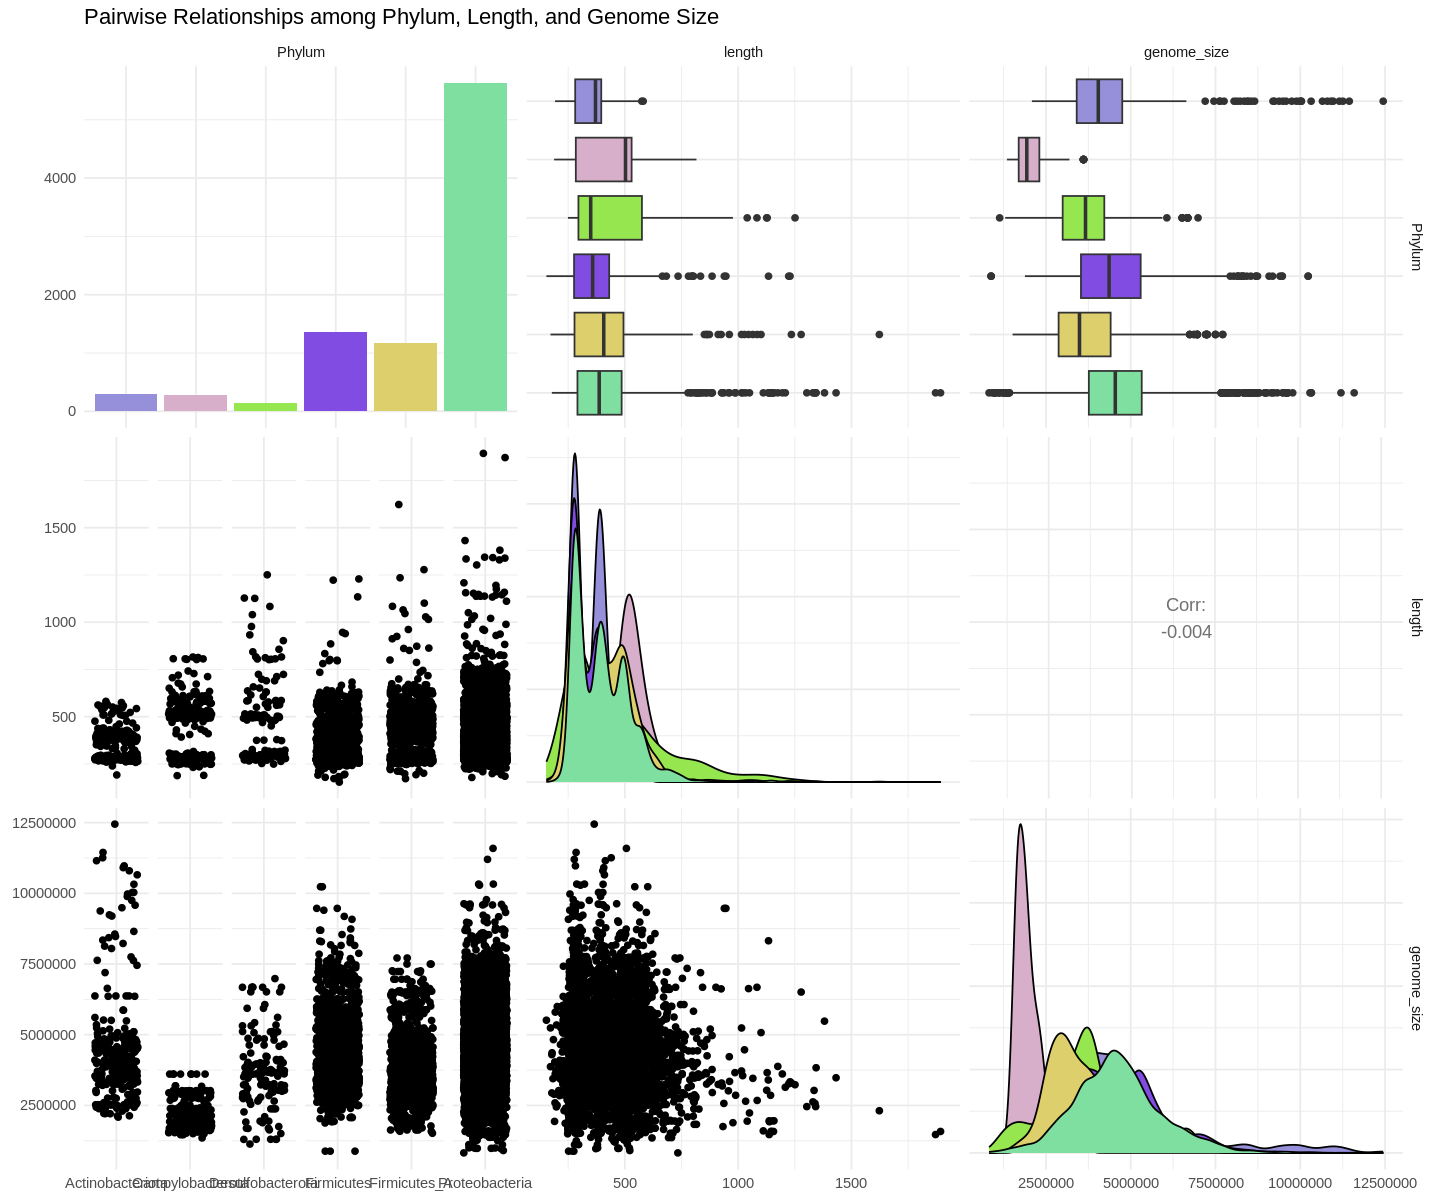

In [128]:
library(GGally)

# Scatterplot matrix
ggpairs(fla.taxonomy.length.top10, columns = c("Phylum", "length", "genome_size"), aes(fill=Phylum),
        lower = list(continuous = "points", combo = "dot"), 
        diag = list(continuous = "density", combo = "bar",alpha=0.6), 
        title = "Pairwise Relationships among Phylum, Length, and Genome Size") + 
        scale_fill_manual(values = phylum_colors)+ 
  scale_size_area() +
  theme(axis.text.x = element_text(size = 12,angle=45,hjust=1),
        axis.text.y = element_text(size = 12),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        strip.text = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        panel.spacing = unit(0.4, "cm"))+
theme_minimal()

In [140]:
length.per.phylum = count(fla.taxonomy.length,Genus,Phylum,length,sort=TRUE)

In [138]:
head(length.per.phylum,sort=T)

Phylum            Genus                length n 
1 p__Proteobacteria g__Vibrio            377    40
2 p__Proteobacteria g__Vibrio            379    16
3 p__Proteobacteria g__Vibrio            378    15
4 p__Proteobacteria g__Paracoccus        280    13
5 p__Proteobacteria g__Pseudoalteromonas 261    12
6 p__Firmicutes_A   g__Clostridium       278    11

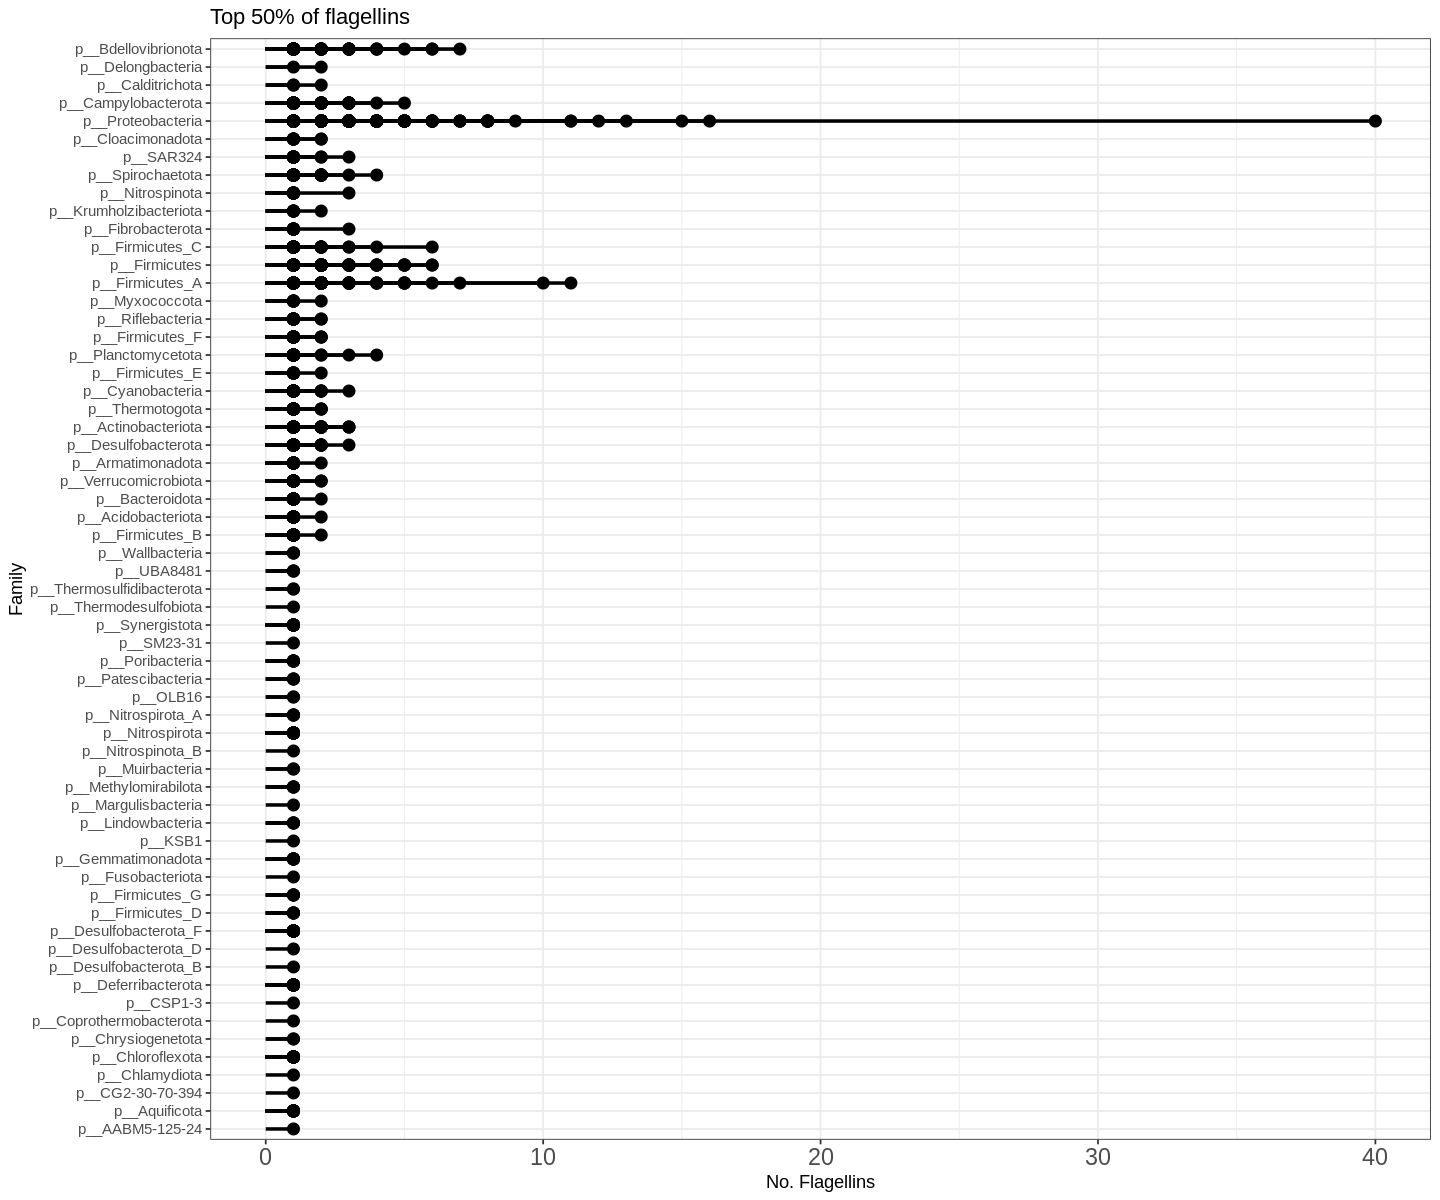

In [141]:
ggplot(length.per.phylum,aes(y=reorder(Phylum,n,descending=TRUE),x=n))+
                        geom_segment(aes(yend=Phylum,xend=0),size=1)+
                        geom_point(size=3)+
                        labs(x="No. Flagellins",y="Family")+
                        scale_color_npg()+
                        guides(scale="none")+
                        theme_bw()+
                        ggtitle("Top 50% of flagellins")+
                        theme(axis.text.x= element_text(size=14),
                             axis.text.y=element_text(size=9),
                             legend.text = element_text(size=12),
                             legend.title = element_text(size=12)
                             )

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.”


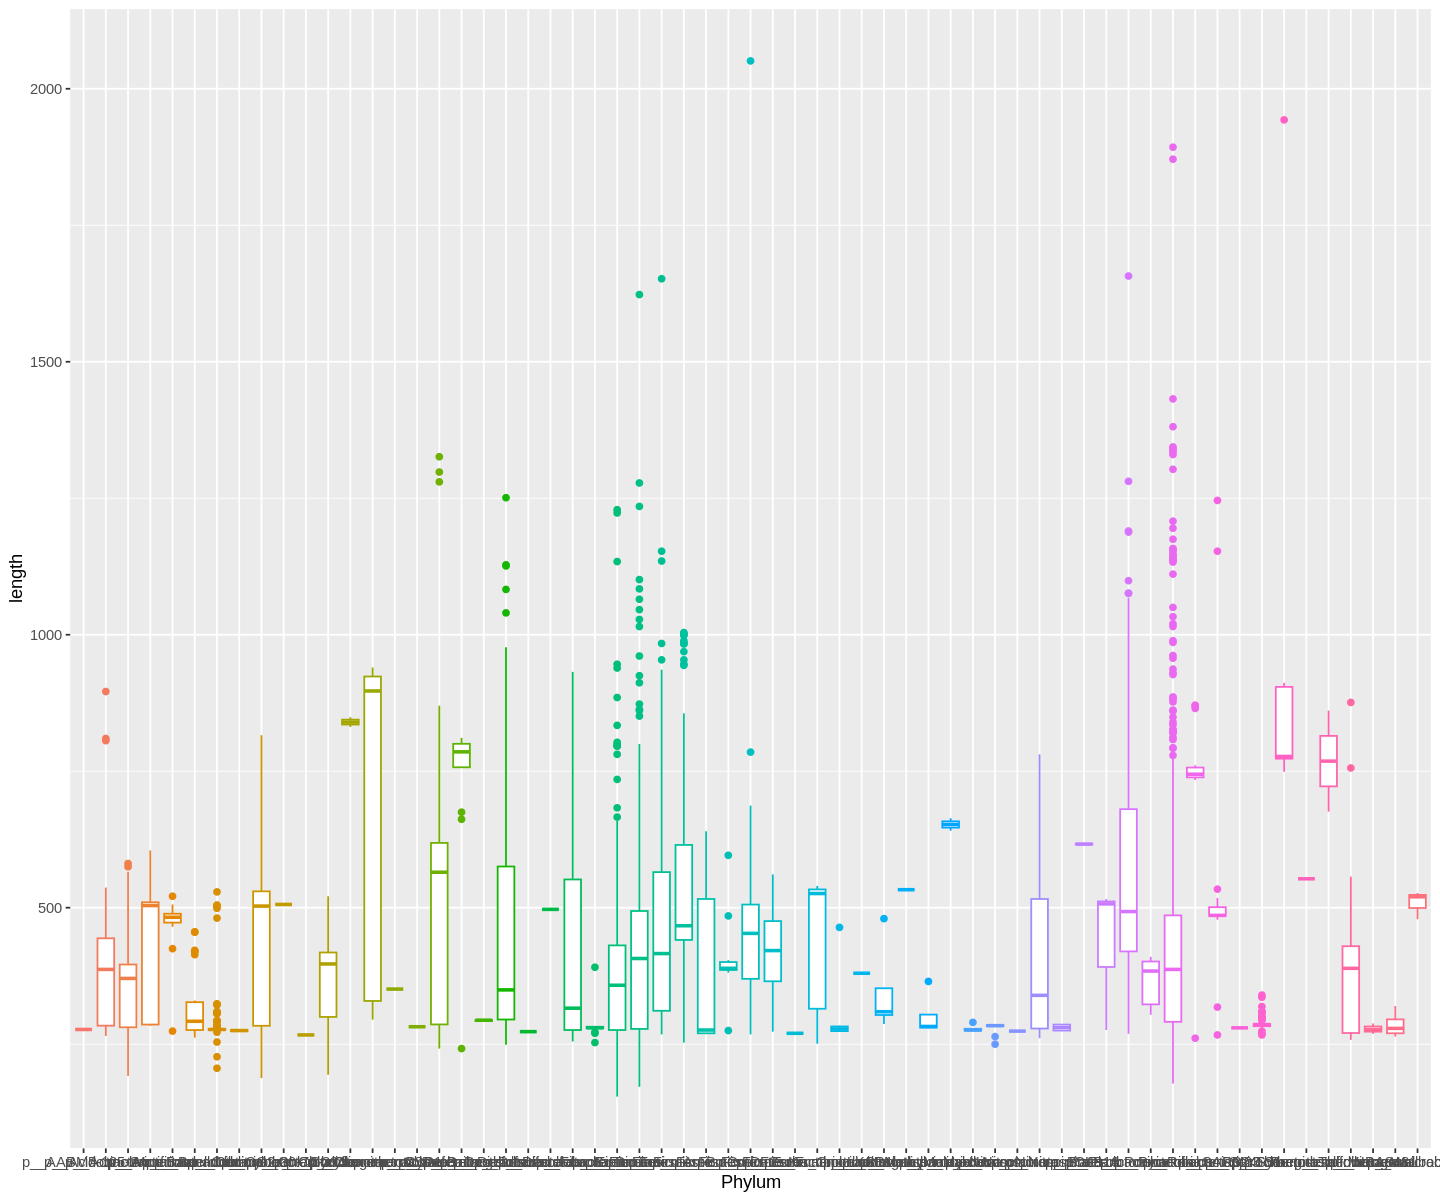

In [133]:
ggplot(data=fla.taxonomy.length,aes(x=Phylum,y=length,color=Phylum))+
            geom_boxplot()+
            guides(color=FALSE)

### Import tree

In [142]:
all.tre = read_tree("/ebio/abt3_projects/small_projects/aborbon/Thesis_FlagellinDiversity/1_shortbred/fasttree_trimal_mafft_alignment_fla_sb.tre")

In [143]:
#Assign new tip labels - Accession names have conflicts with iTOL
tips <- all.tre$tip.label
flaID <- paste("fla",1:length(tips), sep = "")
dat <- data.frame(tips, flaID)

In [144]:
#Rename tip labels 
ntree <- sub.taxa.label(all.tre, dat)

In [145]:
dat.tre <- rename(dat,Accession="tips") %>% inner_join(fla.taxonomy.length)

Joining with `by = join_by(Accession)`


In [146]:
#write_tsv(dat.tre,"../flagellin_phylogeny/fla.sb.taxonomy.length.tsv")

In [147]:
head(dat.tre)

Accession      flaID genome_size gtdb_genome_representative
1 SNX72910.1     fla1  4511824     RS_GCF_900207585.1        
2 KNY28622.1     fla2  6630821     RS_GCF_001262605.1        
3 KJR47801.1     fla3  5311733     RS_GCF_000960765.1        
4 WP_092074313.1 fla4  4130502     RS_GCF_900104455.1        
5 WP_052504473.1 fla5  4753727     RS_GCF_008180865.1        
6 OME87138.1     fla6  7846829     RS_GCF_001956295.1        
  ncbi_genome_category ncbi_genome_representation ncbi_assembly_level
1 none                 full                       Scaffold           
2 none                 full                       Scaffold           
3 none                 full                       Contig             
4 none                 full                       Scaffold           
5 none                 full                       Contig             
6 none                 full                       Contig             
  ncbi_assembly_name                      ncbi_assembly_type
1 IMG-taxon 2740891863 annotated assembly na                
2 ASM74584v1                              na                
3 ASM96076v1                              na                
4 IMG-taxon 2622736508 annotated assembly na                
5 ASM818081v1                             na                
6 ASM195629v1                             na                
  ncbi_genbank_assembly_accession ⋯ HVR_length ncbi_taxid ncbi_phylum
1 GCA_900207585.1                 ⋯  30        1448271    Firmicutes 
2 GCA_000745845.1                 ⋯ 806         398512    Firmicutes 
3 GCA_000960765.1                 ⋯ 154        1617025    Firmicutes 
4 GCA_900104455.1                 ⋯ 171         146817    Firmicutes 
5 GCA_008180815.1                 ⋯ 126         189382    Firmicutes 
6 GCA_001956295.1                 ⋯ 154        1920420    Firmicutes 
  Domain      Phylum          Class                 Order                  
1 d__Bacteria p__Firmicutes   c__Bacilli            o__Bacillales_B        
2 d__Bacteria p__Firmicutes_A c__Clostridia         o__Acetivibrionales    
3 d__Bacteria p__Firmicutes_B c__Desulfitobacteriia o__Desulfitobacteriales
4 d__Bacteria p__Firmicutes_C c__Negativicutes      o__Selenomonadales_A   
5 d__Bacteria p__Firmicutes   c__Bacilli            o__Bacillales_B        
6 d__Bacteria p__Firmicutes   c__Bacilli            o__Paenibacillales     
  Family                    Genus               
1 f__Caldibacillaceae_A     g__Bacillus_BF      
2 f__Acetivibrionaceae      g__Pseudobacteroides
3 f__Desulfitobacteriaceae  g__Desulfosporosinus
4 f__Dendrosporobacteraceae g__Dendrosporobacter
5 f__Bacillaceae_B          g__Rossellomorea    
6 f__Paenibacillaceae       g__Paenibacillus_C  
  Species                            
1 s__Bacillus_BF oleivorans          
2 s__Pseudobacteroides cellulosolvens
3 s__Desulfosporosinus sp000960765   
4 s__Dendrosporobacter quercicolus   
5 s__Rossellomorea aquimaris_D       
6 s__Paenibacillus_C sp001956295

In [148]:
hist(dplyr::count(dat.tre,Phylum)$n,breaks=1000,xlim=c(0,20))

In [149]:
phyla.counts=dplyr::count(dat.tre,Phylum)

In [150]:
order.phyla=arrange(phyla.counts,desc(n))

In [151]:
nrow(order.phyla)

[1] 61

In [152]:
library(RColorBrewer)

In [153]:
cols = colorRampPalette(c("red","green"))(20)

In [154]:
cols =c(brewer.pal(12,"Paired"),rep("#3A3B3C",49))

In [155]:
length(cols)

[1] 61

In [156]:
colors.phyla = data.frame(order.phyla,cols)

In [157]:
head(colors.phyla)

Phylum              n    cols   
1 p__Proteobacteria   5637 #A6CEE3
2 p__Firmicutes       1361 #1F78B4
3 p__Firmicutes_A     1167 #B2DF8A
4 p__Actinobacteriota  304 #33A02C
5 p__Campylobacterota  280 #FB9A99
6 p__Desulfobacterota  142 #E31A1C

In [158]:
flagellins.with.colors = left_join(dat.tre,colors.phyla,by="Phylum")

In [159]:
phylum.cols.itol = select(flagellins.with.colors,flaID,cols,Phylum)

In [160]:
head(phylum.cols.itol)

flaID cols    Phylum         
1 fla1  #1F78B4 p__Firmicutes  
2 fla2  #B2DF8A p__Firmicutes_A
3 fla3  #6A3D9A p__Firmicutes_B
4 fla4  #FF7F00 p__Firmicutes_C
5 fla5  #1F78B4 p__Firmicutes  
6 fla6  #1F78B4 p__Firmicutes

In [ ]:
write_tsv(phylum.cols.itol,"../flagellin_phylogeny/phylum.colors.itol.tsv")

In [ ]:
write.tree(ntree,"../flagellin_phylogeny/fasttree_trimal_mafft_alignment_fla_sb_newLabels.tre")

In [ ]:
write_tsv(dat.tre,"../flagellin_phylogeny/metadata_tree_newLabels.tsv")

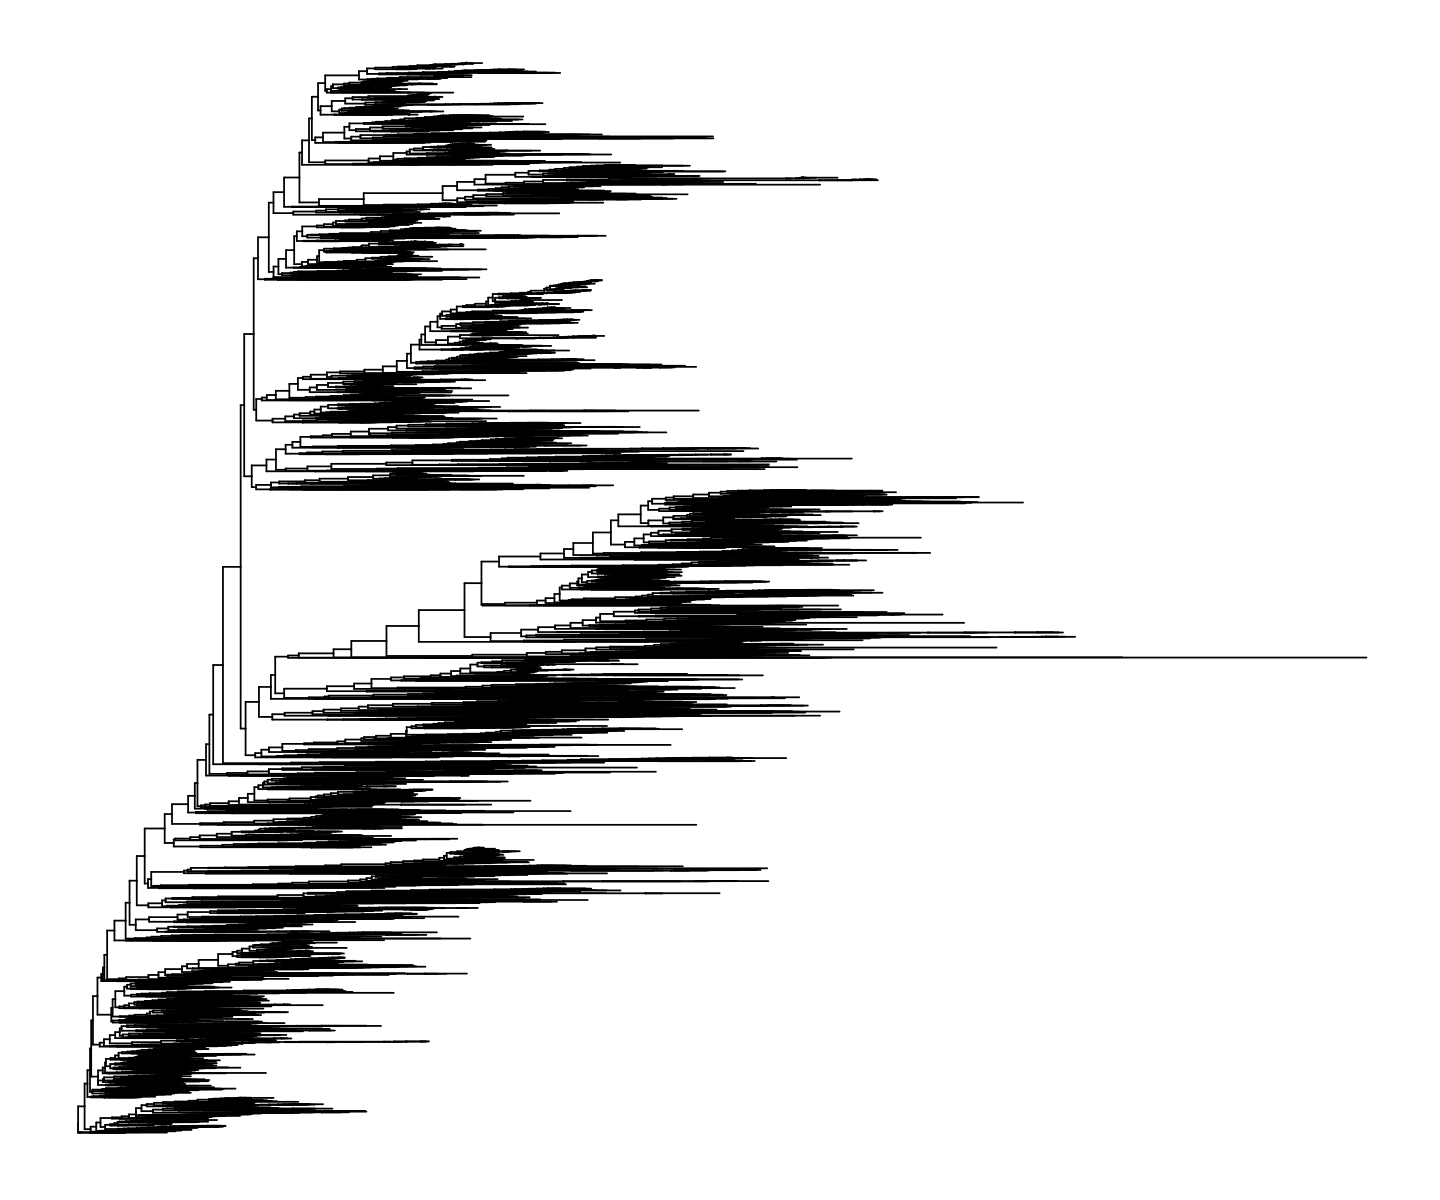

In [161]:
ggplot(all.tre) + geom_tree() + theme_tree()

## Run phylosignal

Phylogeny produced with fasttree and masked alignment

Midpoint root the phylogeny

In [162]:
phy = midpoint.root(ntree)

In [163]:
head(dat.tre)

Accession      flaID genome_size gtdb_genome_representative
1 SNX72910.1     fla1  4511824     RS_GCF_900207585.1        
2 KNY28622.1     fla2  6630821     RS_GCF_001262605.1        
3 KJR47801.1     fla3  5311733     RS_GCF_000960765.1        
4 WP_092074313.1 fla4  4130502     RS_GCF_900104455.1        
5 WP_052504473.1 fla5  4753727     RS_GCF_008180865.1        
6 OME87138.1     fla6  7846829     RS_GCF_001956295.1        
  ncbi_genome_category ncbi_genome_representation ncbi_assembly_level
1 none                 full                       Scaffold           
2 none                 full                       Scaffold           
3 none                 full                       Contig             
4 none                 full                       Scaffold           
5 none                 full                       Contig             
6 none                 full                       Contig             
  ncbi_assembly_name                      ncbi_assembly_type
1 IMG-taxon 2740891863 annotated assembly na                
2 ASM74584v1                              na                
3 ASM96076v1                              na                
4 IMG-taxon 2622736508 annotated assembly na                
5 ASM818081v1                             na                
6 ASM195629v1                             na                
  ncbi_genbank_assembly_accession ⋯ HVR_length ncbi_taxid ncbi_phylum
1 GCA_900207585.1                 ⋯  30        1448271    Firmicutes 
2 GCA_000745845.1                 ⋯ 806         398512    Firmicutes 
3 GCA_000960765.1                 ⋯ 154        1617025    Firmicutes 
4 GCA_900104455.1                 ⋯ 171         146817    Firmicutes 
5 GCA_008180815.1                 ⋯ 126         189382    Firmicutes 
6 GCA_001956295.1                 ⋯ 154        1920420    Firmicutes 
  Domain      Phylum          Class                 Order                  
1 d__Bacteria p__Firmicutes   c__Bacilli            o__Bacillales_B        
2 d__Bacteria p__Firmicutes_A c__Clostridia         o__Acetivibrionales    
3 d__Bacteria p__Firmicutes_B c__Desulfitobacteriia o__Desulfitobacteriales
4 d__Bacteria p__Firmicutes_C c__Negativicutes      o__Selenomonadales_A   
5 d__Bacteria p__Firmicutes   c__Bacilli            o__Bacillales_B        
6 d__Bacteria p__Firmicutes   c__Bacilli            o__Paenibacillales     
  Family                    Genus               
1 f__Caldibacillaceae_A     g__Bacillus_BF      
2 f__Acetivibrionaceae      g__Pseudobacteroides
3 f__Desulfitobacteriaceae  g__Desulfosporosinus
4 f__Dendrosporobacteraceae g__Dendrosporobacter
5 f__Bacillaceae_B          g__Rossellomorea    
6 f__Paenibacillaceae       g__Paenibacillus_C  
  Species                            
1 s__Bacillus_BF oleivorans          
2 s__Pseudobacteroides cellulosolvens
3 s__Desulfosporosinus sp000960765   
4 s__Dendrosporobacter quercicolus   
5 s__Rossellomorea aquimaris_D       
6 s__Paenibacillus_C sp001956295

In [ ]:
flagellin.sizes = write_tsv(dat.tre,"edgeR/flagellin.lengths.taxonomy.tsv")

In [164]:
#Create traits dataframe
traits.length= select(dat.tre,flaID,length,genome_size)

In [165]:
head(traits.length)

flaID length genome_size
1 fla1   270   4511824    
2 fla2  1046   6630821    
3 fla3   394   5311733    
4 fla4   411   4130502    
5 fla5   366   4753727    
6 fla6   394   7846829

##### Create trait list for phylosignal object

In [166]:
#Create trait list for phylosignal object
dat <- list()
dat$length <- traits.length$length
dat$genome_size <- traits.length$genome_size
dat <- as.data.frame(dat)
rownames(dat) = traits.length$flaID
head(dat)

length genome_size
fla1  270   4511824    
fla2 1046   6630821    
fla3  394   5311733    
fla4  411   4130502    
fla5  366   4753727    
fla6  394   7846829

##### Create phylosignal object

In [167]:
#Create phylosignal object
p4d <- phylobase::phylo4d(phy, dat)

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’ ‘tidytree’

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


##### Testing phylosignal

In [168]:
#Test phylosignal hypothesis using Pagel's Lambda method for categorical traits
phylosignal.finalset=phyloSignal(p4d,methods=c("Lambda","Cmean"))
#phylosignal.finalset

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


In [169]:
phylosignal.finalset

$stat
                Cmean    Lambda
length      0.7655965 0.9882299
genome_size 0.6941262 0.9683902

$pvalue
            Cmean Lambda
length      0.001  0.001
genome_size 0.001  0.001

In [ ]:
hvrlength.crlg <- phyloCorrelogram(p4d, trait = "length")
plot(hvrlength.crlg)

In [ ]:
plot(hvrlength.crlg)

In [ ]:
#flag.lipa <- lipaMoran(p4d)
flag.lipa.p4d <- lipaMoran(p4d, as.p4d = TRUE)

In [ ]:
flag.lipa.p4d

In [ ]:
barplot.phylo4d(flag.lipa.p4d, bar.col=(flag.lipa$p.value < 0.05) + 1, center = FALSE , scale = FALSE,label.type=T)

In [ ]:
library(phylosignal)

In [ ]:
barplot.phylo4d(p4d, tree.type = "phylo", tree.ladderize = TRUE, show.box = TRUE,
                scale = TRUE, tree.ratio = 0.3, col = c("blue", "red"),
                tip.labels = TRUE, cex.lab = 1.5, cex.axis = 1.2,
                main = "Phylogenetic signal of flagellin sequence length")

In [ ]:
barplot.phylo4d(p4d,tree.type = "phylo", tree.ladderize = TRUE,show.box = T,scale=T,tree.ratio = 0.3)

In [ ]:
#phylosim <- phyloSim(tree = phy, method = c("Cmean","Lambda"), nsim = 100, reps = 99)
#phylosim

## Descriptive stats - metadata 

In [ ]:
fla.full.metadata = inner_join(length.seqs,taxonomy.full.db,by="Accession")%>%
separate(gtdb_taxonomy,into=c("gtdb_Domain","gtdb_Phylum","gtdb_Class","gtdb_Order","gtdb_Family","gtdb_Genus","gtdb_Species"),sep=";")

In [ ]:
names(fla.full.metadata)

In [ ]:
hist(order.phyla$n,breaks=50)
abline(v=median(order.phyla$n),col="blue")
abline(v=mean(order.phyla$n),col="blue")

In [ ]:
tmp =filter(order.phyla,n<150)
hist(tmp$n,breaks=50)
abline(v=median(tmp$n),col="blue")
abline(v=mean(tmp$n),col="blue")

In [ ]:
count(fla.full.metadata,ncbi_genbank_assembly_accession)

In [ ]:
#per.genome.count = count(fla.full.metadata,ncbi_genbank_assembly_accession)
stats.per.genome = tibble(nrow(fla.full.metadata),
                          min = min(count(fla.full.metadata,gtdb_genome_representative)$n),
                          max = max(count(fla.full.metadata,gtdb_genome_representative)$n),
                          median = median(count(fla.full.metadata,gtdb_genome_representative)$n),
                          mean = mean(count(fla.full.metadata,gtdb_genome_representative)$n))
stats.per.genome

In [ ]:
hist(count(full.genomes,gtdb_genome_representative)$n,breaks=50)

In [ ]:
full.genomes = filter(fla.full.metadata,ncbi_assembly_level==c("Complete Genome"))

In [ ]:
hist(count(full.genomes,ncbi_genbank_assembly_accession)$n,breaks=50)

In [ ]:
names(full.genomes)

In [ ]:
hist(count(full.genomes,gtdb_Genus)$n,breaks=50)

In [ ]:
phylum.count = count(full.genomes,gtdb_Phylum)

In [ ]:
head(phylum.count)

In [ ]:
hist(phylum.count$n,breaks=50)

In [ ]:
median(phylum.count$n)

In [ ]:
ggplot(data = full.genomes, aes(x=gtdb_Phylum,y=length))+ geom_boxplot()

In [ ]:
stats.full.genome = tibble(nrow(full.genomes),
                          min = min(count(full.genomes,gtdb_Genus)$n),
                          max = max(count(full.genomes,gtdb_Genus)$n),
                          median = median(count(full.genomes,gtdb_Genus)$n),
                          mean = mean(count(full.genomes,gtdb_Genus)$n))
stats.full.genome

In [ ]:
chromosome = filter(fla.full.metadata,ncbi_assembly_level=="Chromosome")

In [ ]:
count.assembly = count(chromosome,ncbi_genbank_assembly_accession)

In [ ]:
filter(count.assembly,n>10)

In [ ]:
filter(fla.full.metadata,ncbi_genbank_assembly_accession=="GCA_002504205.1")%>%
select(c(Accession,gtdb_Genus,gtdb_Species,length,gtdb_genome_representative))

In [ ]:
hist(count(chromosome,ncbi_genbank_assembly_accession)$n,breaks=50)
hist(count(chromosome,gtdb_Species)$n,breaks=50)